In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from collections import Counter
from openpyxl import load_workbook


In [ ]:
def fill_excel_from_result_df(result_df: pd.DataFrame, excel_path: str, output_path: str = "filled_metrics_spec.xlsx", target_model: str = None):
    """
    Fills an Excel metrics spec sheet using result DataFrame for a specific model.

    Parameters:
    - result_df (pd.DataFrame): Must contain 'group', 'pred_len', 'mse', 'wape'
    - excel_path (str): Path to input Excel file (template)
    - output_path (str): Where to save the updated Excel file
    - target_model (str): If specified, only fill data for this model
    """

    wb = load_workbook(excel_path)
    ws = wb.active

    # Parse all model name columns
    model_col_map = {}
    for col in range(2, ws.max_column + 1, 2):
        model = ws.cell(row=1, column=col).value
        if model is None:
            continue
        model = model.strip()
        model_col_map[model] = {
            'MSE': col,
            'WAPE': col + 1,
        }

    # Optional: restrict to a specific model
    if target_model:
        target_model = target_model.strip()
        if target_model not in model_col_map:
            raise ValueError(f"Model '{target_model}' not found in Excel headers.")
        model_col_map = {target_model: model_col_map[target_model]}

    for row in range(3, ws.max_row + 1):
        # Get prediction length
        try:
            pred_len = int(ws.cell(row=row, column=1).value)
        except (ValueError, TypeError):
            continue

        # Backtrace to find current group name
        group = None
        for r in range(row, 0, -1):
            val = ws.cell(row=r, column=1).value
            if isinstance(val, str) and "_" in val:
                group = val.strip()
                break
        if not group:
            continue

        # Match result row
        matched = result_df[(result_df['group'] == group) & (result_df['pred_len'] == pred_len)]
        if matched.empty:
            continue

        metrics = matched.iloc[0]
        for model_name, col_map in model_col_map.items():
            if 'mse' in metrics and pd.notna(metrics['mse']):
                ws.cell(row=row, column=col_map['MSE'], value=round(metrics['mse'], 6))
            if 'wape' in metrics and pd.notna(metrics['wape']):
                ws.cell(row=row, column=col_map['WAPE'], value=round(metrics['wape'], 6))

    wb.save(output_path)
    print(f"✅ Excel updated for model(s): {', '.join(model_col_map)} → saved to {output_path}")


In [ ]:

def show_results(root_dir):
    summary_results = []
    total_json_count = 0
    all_model_paths = []

    # === Traverse and summarize ===
    for group_dir in sorted(root_dir.iterdir()):
        if not group_dir.is_dir():
            continue

        metrics_list = []

        for subdir in group_dir.iterdir():
            if not subdir.is_dir():
                continue

            json_file = subdir / "results.json"
            if json_file.exists():
                total_json_count += 1
                with open(json_file, "r") as f:
                    data = json.load(f)
                    data["group"] = group_dir.name
                    metrics_list.append(data)
                    all_model_paths.append(data.get("model_path", "unknown"))

        if metrics_list:
            df = pd.DataFrame(metrics_list)
            df_mean = df.drop(columns=["dataset", "freq", "model_path"]).mean(numeric_only=True)
            df_mean["group"] = group_dir.name
            summary_results.append(df_mean)

    # === Combine summaries ===
    summary_df = pd.DataFrame(summary_results)
    summary_df.sort_values("group", inplace=True)

    # === Display summary table ===
    print("\n📊 Summary of Mean Metrics per Dataset Group:")
    display(summary_df)

    # === Compute overall global mean across all groups ===
    global_means = summary_df.drop(columns=["group"]).mean(numeric_only=True)
    print("\n📌 Global Mean Across All Groups:")
    print(global_means.round(4))

    # === Determine model name to display in title ===
    model_name = Counter(all_model_paths).most_common(1)[0][0] if all_model_paths else "Unknown Model"

    # === Visualization ===
    plt.figure(figsize=(12, 6))
    for metric in ["mse", "mae", "smape", "wape", "nrmse"]:
        if metric in summary_df.columns:
            plt.plot(summary_df["group"], summary_df[metric], marker='o', label=metric)

    plt.xticks(rotation=45)
    plt.xlabel("Dataset Group")
    plt.ylabel("Metric Value")
    plt.title(f"Average Forecasting Metrics by Dataset Group\nModel: {model_name} pred len: {summary_df['pred_len'][0]} context len: {summary_df['context_len'][0]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Total json count ===
    print(f"\n🔢 Total number of results.json files found: {total_json_count}")

    return summary_df

In [ ]:
excel_file_path = r''

## TimesFM 200m


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.092608  0.255055  0.138591  0.182649  0.390547   3693.333333   
1   0.012949  0.172356  0.066786  0.076747  0.130814  20880.000000   
2   0.019192  0.194858  0.076654  0.091778  0.166112   8853.333333   
3   0.060080  0.235827  0.135246  0.151250  0.262754   6920.000000   
4   0.018419  0.185430  0.080419  0.095245  0.156918  20720.000000   
5   0.054268  0.261148  0.129388  0.149344  0.254971  12200.000000   
6   0.422649  0.710717  0.408444  0.524546  0.835369   2040.000000   
7   0.077344  0.345456  0.133580  0.177281  0.364478   7280.000000   
8   0.021575  0.154593  0.076712  0.086801  0.166202  16160.000000   
9   0.192662  0.347075  0.200278  0.242223  0.381411   9140.000000   
10  0.206818  0.410720  0.290308  0.326144  0.510910   2040.000000   
11  0.140892  0.361245  0.178931  0.221495  0.420251   6843.948498   
12  0.099135  0.358949  0.167560  0.205137  0.364732   5714.333333   
13  0.228769  0.532003  0.269209  0.338498  0.588310   3010.427350   
14  0.250448  0.484874  0.269965  0.332637  0.593220   2347.058824   

         abs_sum  total_time  pred_len  context_len                 group  
0    2888.451090    3.994347      10.0        128.0           crypto10_1d  
1   18160.546875   22.872678      10.0        128.0           crypto10_1h  
2    7392.073730   10.196857      10.0        128.0           crypto10_1m  
3    6179.074219    7.546202      10.0        128.0     forex_datasets_1d  
4   17725.246745   23.275421      10.0        128.0     forex_datasets_1h  
5   10563.588867   13.754068      10.0        128.0     forex_datasets_1m  
6    1600.562581    2.217127      10.0        128.0    forex_datasets_1wk  
7    5514.909912    8.090483      10.0        128.0   futures_datasets_1d  
8   14281.680664   17.855382      10.0        128.0   futures_datasets_1h  
9    7848.489827   10.493158      10.0        128.0   futures_datasets_1m  
10   1815.848755    2.311070      10.0        128.0  futures_datasets_1wk  
11   5616.210387    8.184127      10.0        128.0     stock_datasets_1d  
12   4743.234716    6.807629      10.0        128.0     stock_datasets_1h  
13   2416.079607    3.587693      10.0        128.0     stock_datasets_1m  
14   1938.974565    2.791068      10.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1265
smape              0.3340
mae                0.1748
wape               0.2135
nrmse              0.3725
num_elements    8522.8290
abs_sum         7245.6648
total_time         9.5985
pred_len          10.0000
context_len      128.0000
dtype: float64


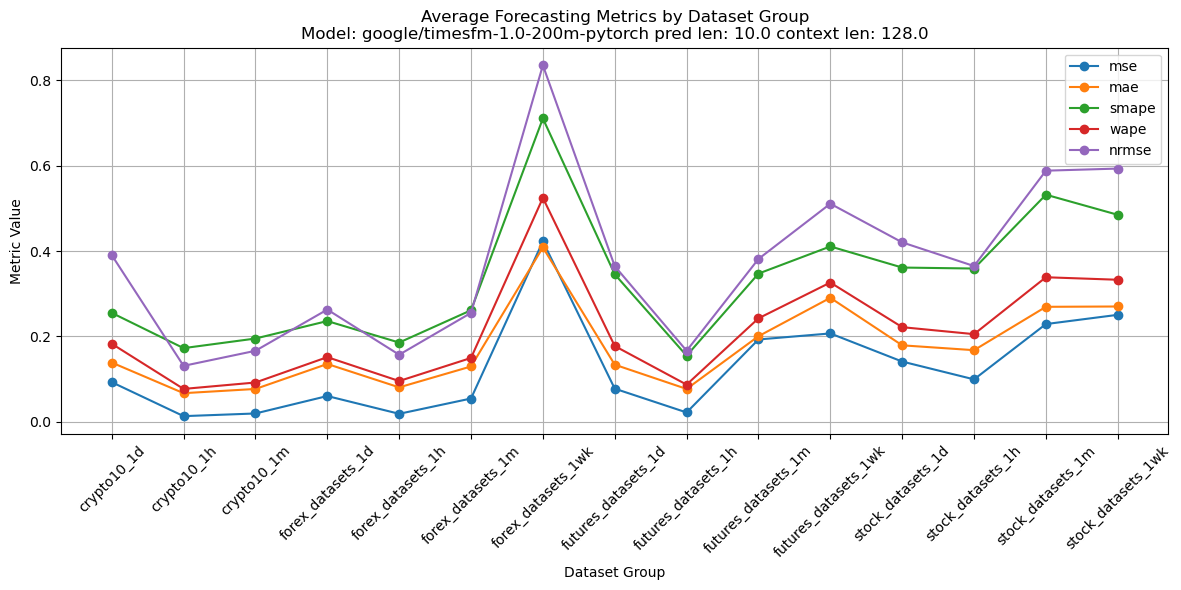


🔢 Total number of results.json files found: 908


In [ ]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_200m_of1\h10")
summary_df = show_results(root_dir)

#data load into excel

fill_excel_from_result_df(summary_df, excel_path=excel_file_path, output_path=excel_file_path)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.188394  0.334150  0.202652  0.268382  0.561755   3653.333333   
1   0.022497  0.218380  0.091526  0.105182  0.172451  20880.000000   
2   0.044851  0.254009  0.118202  0.141793  0.253876   8853.333333   
3   0.104252  0.321491  0.194477  0.217566  0.350702   6920.000000   
4   0.036663  0.246061  0.117000  0.138566  0.221180  20693.333333   
5   0.093660  0.327263  0.173241  0.200199  0.332143  12160.000000   
6   0.829629  0.919822  0.610918  0.787282  1.175640   2000.000000   
7   0.163540  0.458918  0.199860  0.266064  0.533969   7240.000000   
8   0.042121  0.217544  0.115100  0.130238  0.232227  16160.000000   
9   0.222697  0.396909  0.235595  0.283884  0.446315   9120.000000   
10  0.407199  0.571479  0.408946  0.467403  0.729338   2000.000000   
11  0.262942  0.466580  0.259611  0.322463  0.578735   6817.510730   
12  0.194421  0.464067  0.243530  0.298547  0.512187   5707.333333   
13  0.426828  0.675428  0.386891  0.488716  0.808360   2988.034188   
14  0.479056  0.626767  0.394128  0.490268  0.832614   2314.823529   

         abs_sum  total_time  pred_len  context_len                 group  
0    2840.513428    1.161069      20.0        128.0           crypto10_1d  
1   18160.557617    6.577403      20.0        128.0           crypto10_1h  
2    7392.073242    2.764555      20.0        128.0           crypto10_1m  
3    6179.074707    2.385353      20.0        128.0     forex_datasets_1d  
4   17704.054688    6.741689      20.0        128.0     forex_datasets_1h  
5   10519.006510    4.098102      20.0        128.0     forex_datasets_1m  
6    1563.865031    0.724654      20.0        128.0    forex_datasets_1wk  
7    5461.366089    2.383881      20.0        128.0   futures_datasets_1d  
8   14281.685547    5.438113      20.0        128.0   futures_datasets_1h  
9    7832.895752    3.067882      20.0        128.0   futures_datasets_1m  
10   1749.862793    0.849830      20.0        128.0  futures_datasets_1wk  
11   5585.289581    2.211349      20.0        128.0     stock_datasets_1d  
12   4735.984174    1.844588      20.0        128.0     stock_datasets_1h  
13   2386.358324    0.984699      20.0        128.0     stock_datasets_1m  
14   1895.490369    0.764773      20.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.2346
smape              0.4333
mae                0.2501
wape               0.3071
nrmse              0.5161
num_elements    8500.5135
abs_sum         7219.2052
total_time         2.7999
pred_len          20.0000
context_len      128.0000
dtype: float64


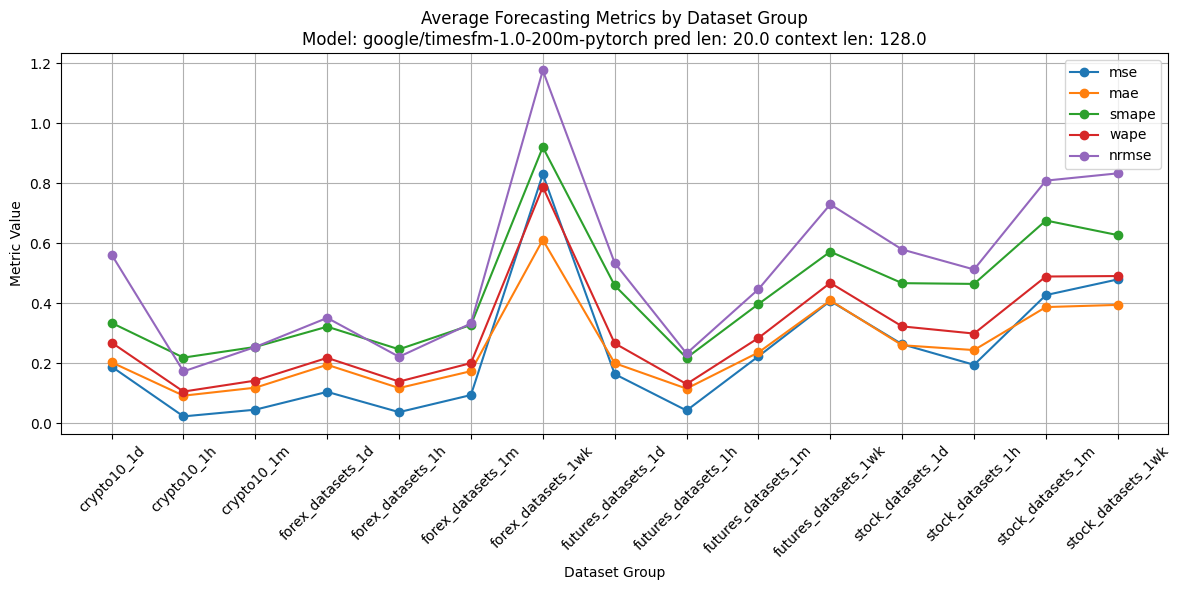


🔢 Total number of results.json files found: 908


In [4]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_200m_of1\h20")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.290396  0.416169  0.265617  0.349766  0.696722   3680.000000   
1   0.033788  0.269520  0.115124  0.132307  0.211345  20880.000000   
2   0.068893  0.308458  0.146914  0.177035  0.316151   8800.000000   
3   0.159889  0.371515  0.242575  0.271295  0.436443   6900.000000   
4   0.055844  0.292803  0.145570  0.173330  0.273048  20640.000000   
5   0.148448  0.414046  0.229119  0.265029  0.421811  12120.000000   
6   1.096010  0.990230  0.725844  0.934296  1.350439   2040.000000   
7   0.231276  0.523705  0.243088  0.324017  0.635384   7200.000000   
8   0.064120  0.283257  0.149996  0.169488  0.286126  16080.000000   
9   0.261452  0.453337  0.275724  0.331327  0.507703   9080.000000   
10  0.664548  0.636118  0.533735  0.599620  0.915827   2040.000000   
11  0.380587  0.542182  0.323750  0.401560  0.698763   6817.339056   
12  0.278675  0.535494  0.300091  0.370535  0.615499   5657.000000   
13  0.630897  0.792640  0.491894  0.624627  0.988567   2970.769231   
14  0.701781  0.716989  0.494945  0.611503  1.000588   2335.058824   

         abs_sum  total_time  pred_len  context_len                 group  
0    2867.131429    1.374428      30.0        128.0           crypto10_1d  
1   18160.559570    7.708606      30.0        128.0           crypto10_1h  
2    7310.747884    3.229276      30.0        128.0           crypto10_1m  
3    6164.434570    2.486581      30.0        128.0     forex_datasets_1d  
4   17603.581380    7.631246      30.0        128.0     forex_datasets_1h  
5   10474.398112    4.458304      30.0        128.0     forex_datasets_1m  
6    1600.562541    0.780504      30.0        128.0    forex_datasets_1wk  
7    5408.967285    2.595062      30.0        128.0   futures_datasets_1d  
8   14230.698242    5.846544      30.0        128.0   futures_datasets_1h  
9    7780.715047    3.336322      30.0        128.0   futures_datasets_1m  
10   1815.848877    0.872790      30.0        128.0  futures_datasets_1wk  
11   5581.527062    2.680847      30.0        128.0     stock_datasets_1d  
12   4669.511446    2.230497      30.0        128.0     stock_datasets_1h  
13   2365.816543    1.168061      30.0        128.0     stock_datasets_1m  
14   1920.600093    0.916184      30.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.3378
smape              0.5031
mae                0.3123
wape               0.3824
nrmse              0.6236
num_elements    8482.6778
abs_sum         7197.0067
total_time         3.1544
pred_len          30.0000
context_len      128.0000
dtype: float64


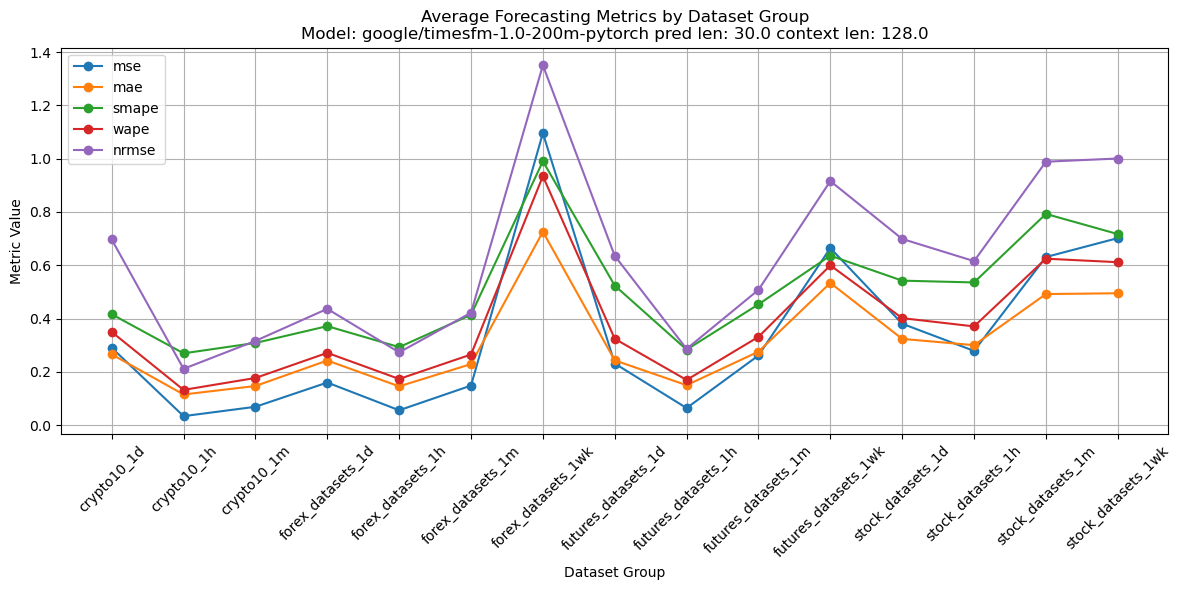


🔢 Total number of results.json files found: 908


In [8]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_200m_of1\h30")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.571246  0.562221  0.397239  0.532316  0.998509   3600.000000   
1   0.073083  0.350614  0.172273  0.197989  0.310806  20880.000000   
2   0.154666  0.420995  0.233014  0.280693  0.473637   8800.000000   
3   0.302304  0.508109  0.357625  0.398764  0.591901   6840.000000   
4   0.111372  0.384621  0.211209  0.251078  0.386633  20560.000000   
5   0.288762  0.529443  0.328838  0.381547  0.595482  12000.000000   
6   1.743990  1.207815  0.953391  1.235216  1.704435   1920.000000   
7   0.499516  0.658212  0.369096  0.498342  0.951142   7080.000000   
8   0.120162  0.355682  0.209828  0.237095  0.391690  16080.000000   
9   0.344902  0.542962  0.349299  0.416965  0.624160   9000.000000   
10  1.351681  0.858581  0.785918  0.910602  1.347064   1920.000000   
11  0.708079  0.700317  0.476895  0.597454  0.962338   6739.570815   
12  0.515973  0.685260  0.433369  0.536767  0.841517   5624.000000   
13  1.078112  0.999393  0.698050  0.892242  1.303879   2924.102564   
14  1.406802  0.941433  0.749875  0.957323  1.467459   2226.352941   

         abs_sum  total_time  pred_len  context_len                 group  
0    2775.409180    0.453118      60.0        128.0           crypto10_1d  
1   18160.557617    2.235666      60.0        128.0           crypto10_1h  
2    7310.747721    0.949188      60.0        128.0           crypto10_1m  
3    6124.638184    0.894300      60.0        128.0     forex_datasets_1d  
4   17539.440104    2.221624      60.0        128.0     forex_datasets_1h  
5   10344.388346    1.286513      60.0        128.0     forex_datasets_1m  
6    1488.001546    0.262985      60.0        128.0    forex_datasets_1wk  
7    5251.835938    0.808788      60.0        128.0   futures_datasets_1d  
8   14230.702148    2.003497      60.0        128.0   futures_datasets_1h  
9    7713.614176    1.057334      60.0        128.0   futures_datasets_1m  
10   1657.105225    0.341105      60.0        128.0  futures_datasets_1wk  
11   5482.854215    0.734318      60.0        128.0     stock_datasets_1d  
12   4633.335434    0.618791      60.0        128.0     stock_datasets_1h  
13   2310.156602    0.323627      60.0        128.0     stock_datasets_1m  
14   1774.437320    0.252032      60.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.6180
smape              0.6470
mae                0.4484
wape               0.5550
nrmse              0.8634
num_elements    8412.9351
abs_sum         7119.8149
total_time         0.9629
pred_len          60.0000
context_len      128.0000
dtype: float64


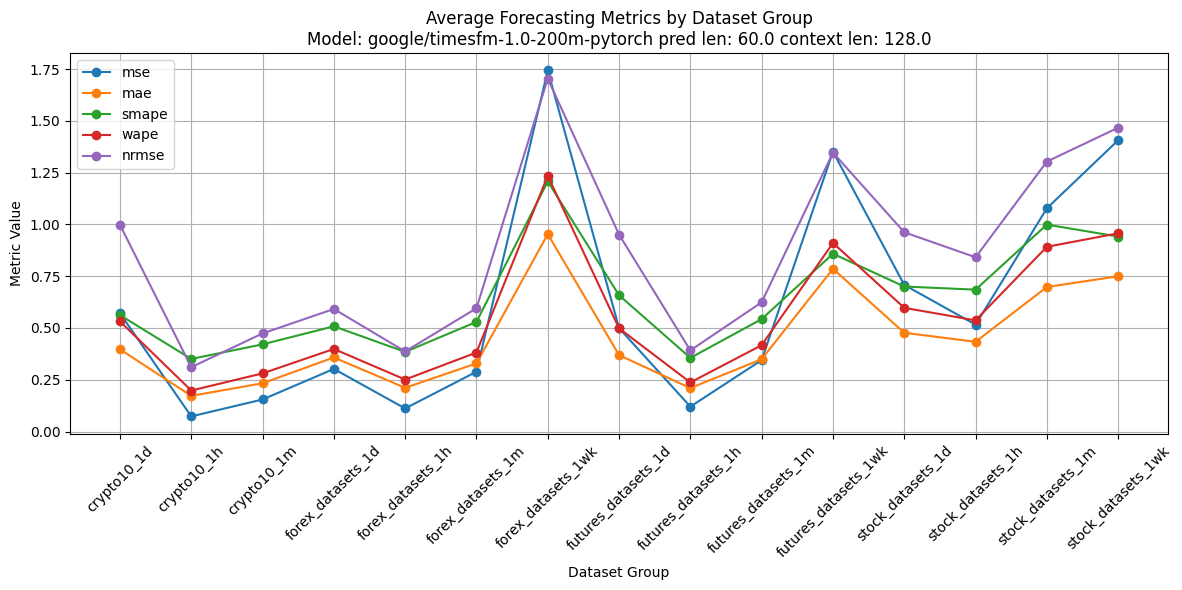


🔢 Total number of results.json files found: 908


In [5]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_200m_of1\h60")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.878540  0.699590  0.539230  0.733351  1.232452   3584.000000   
1   0.108872  0.433038  0.219724  0.253033  0.379804  20736.000000   
2   0.229687  0.532558  0.303543  0.369915  0.581463   8704.000000   
3   0.391134  0.592960  0.405941  0.460200  0.685518   6720.000000   
4   0.184193  0.467761  0.269062  0.319020  0.490193  20608.000000   
5   0.377881  0.598016  0.397903  0.463290  0.688937  11904.000000   
6   3.753291  1.437489  1.531117  1.951451  2.423497   1920.000000   
7   0.718523  0.776135  0.461004  0.614596  1.112553   7200.000000   
8   0.187256  0.474867  0.261675  0.296063  0.489598  16128.000000   
9   0.466167  0.641833  0.431411  0.511711  0.760848   9024.000000   
10  2.294612  1.182176  1.162794  1.347267  1.755116   1920.000000   
11  1.085137  0.854664  0.636143  0.798746  1.198747   6691.158798   
12  0.831249  0.829141  0.581260  0.725672  1.078462   5462.400000   
13  1.597429  1.166892  0.899245  1.183293  1.629609   2784.820513   
14  2.037660  1.115662  0.962630  1.230300  1.769176   2227.200000   

         abs_sum  total_time  pred_len  context_len                 group  
0    2755.319255    0.455593      96.0        128.0           crypto10_1d  
1   18006.963867    2.372696      96.0        128.0           crypto10_1h  
2    7165.317383    0.999717      96.0        128.0           crypto10_1m  
3    5925.901855    0.827379      96.0        128.0     forex_datasets_1d  
4   17631.636068    2.302822      96.0        128.0     forex_datasets_1h  
5   10240.671549    1.363164      96.0        128.0     forex_datasets_1m  
6    1488.001587    0.266966      96.0        128.0    forex_datasets_1wk  
7    5421.123291    0.831817      96.0        128.0   futures_datasets_1d  
8   14254.699219    1.938518      96.0        128.0   futures_datasets_1h  
9    7729.359985    1.016496      96.0        128.0   futures_datasets_1m  
10   1657.105225    0.355468      96.0        128.0  futures_datasets_1wk  
11   5419.960826    0.805668      96.0        128.0     stock_datasets_1d  
12   4471.765122    0.665208      96.0        128.0     stock_datasets_1h  
13   2165.623706    0.337467      96.0        128.0     stock_datasets_1m  
14   1777.973862    0.270662      96.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                1.0094
smape              0.7869
mae                0.6042
wape               0.7505
nrmse              1.0851
num_elements    8374.2386
abs_sum         7074.0949
total_time         0.9873
pred_len          96.0000
context_len      128.0000
dtype: float64


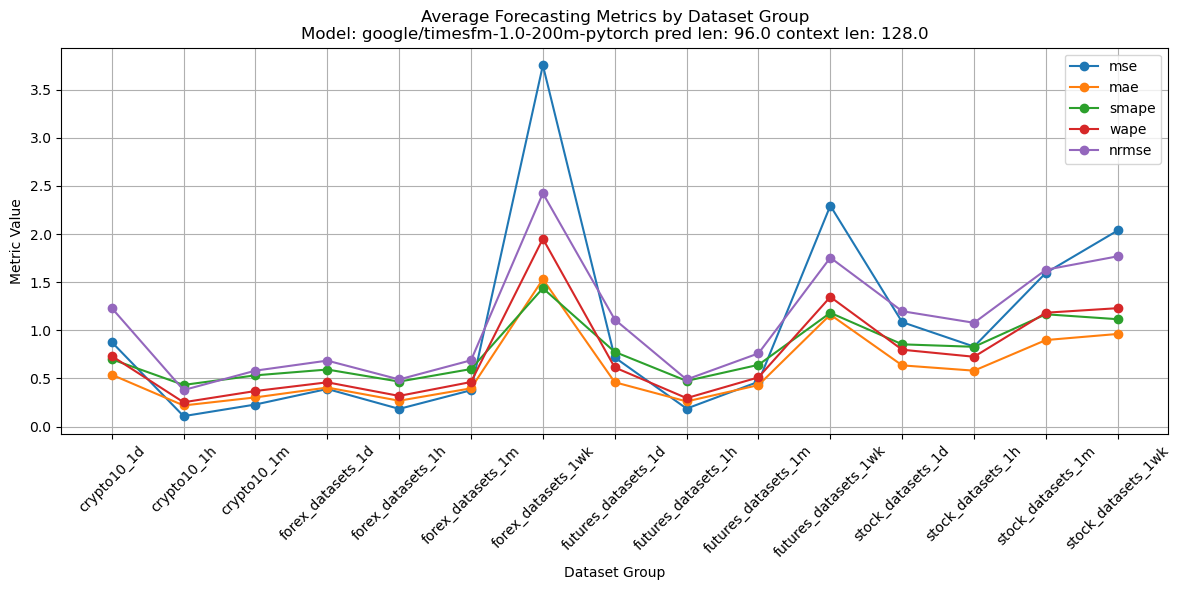


🔢 Total number of results.json files found: 908


In [9]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_200m_of1\h96")
show_results(root_dir)

## TimesFM 500m


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.124720  0.266968  0.148915  0.196768  0.446175   3693.333333   
1   0.013752  0.173226  0.068574  0.078802  0.134810  20880.000000   
2   0.019911  0.190872  0.077266  0.092564  0.169193   8853.333333   
3   0.056182  0.238225  0.135910  0.152098  0.257793   6920.000000   
4   0.019063  0.190962  0.082561  0.097792  0.159448  20720.000000   
5   0.055416  0.253504  0.128341  0.148109  0.258171  12200.000000   
6   0.519808  0.674965  0.401011  0.518700  0.909688   2040.000000   
7   0.081026  0.350428  0.138497  0.183867  0.373944   7280.000000   
8   0.022207  0.160773  0.076282  0.086314  0.168620  16160.000000   
9   0.204984  0.325465  0.196372  0.237291  0.391957   9140.000000   
10  0.192100  0.377510  0.263552  0.296085  0.492395   2040.000000   
11  0.141633  0.364671  0.179364  0.221996  0.422458   6843.948498   
12  0.098185  0.359116  0.166310  0.203598  0.363157   5714.333333   
13  0.219277  0.526381  0.263304  0.331050  0.576084   3010.427350   
14  0.239205  0.481342  0.263198  0.324248  0.580297   2347.058824   

         abs_sum  total_time  pred_len  context_len                 group  
0    2888.451090    3.600215      10.0        128.0           crypto10_1d  
1   18160.546875   20.081943      10.0        128.0           crypto10_1h  
2    7392.073730    8.570558      10.0        128.0           crypto10_1m  
3    6179.074219    6.777006      10.0        128.0     forex_datasets_1d  
4   17725.246745   19.920009      10.0        128.0     forex_datasets_1h  
5   10563.588867   11.779562      10.0        128.0     forex_datasets_1m  
6    1600.562581    2.102903      10.0        128.0    forex_datasets_1wk  
7    5514.909912    7.119717      10.0        128.0   futures_datasets_1d  
8   14281.680664   16.009744      10.0        128.0   futures_datasets_1h  
9    7848.489827    8.949482      10.0        128.0   futures_datasets_1m  
10   1815.848755    2.270305      10.0        128.0  futures_datasets_1wk  
11   5616.210387    6.957036      10.0        128.0     stock_datasets_1d  
12   4743.234716    5.841951      10.0        128.0     stock_datasets_1h  
13   2416.079607    3.081227      10.0        128.0     stock_datasets_1m  
14   1938.974565    2.403571      10.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1338
smape              0.3290
mae                0.1726
wape               0.2113
nrmse              0.3803
num_elements    8522.8290
abs_sum         7245.6648
total_time         8.3643
pred_len          10.0000
context_len      128.0000
dtype: float64


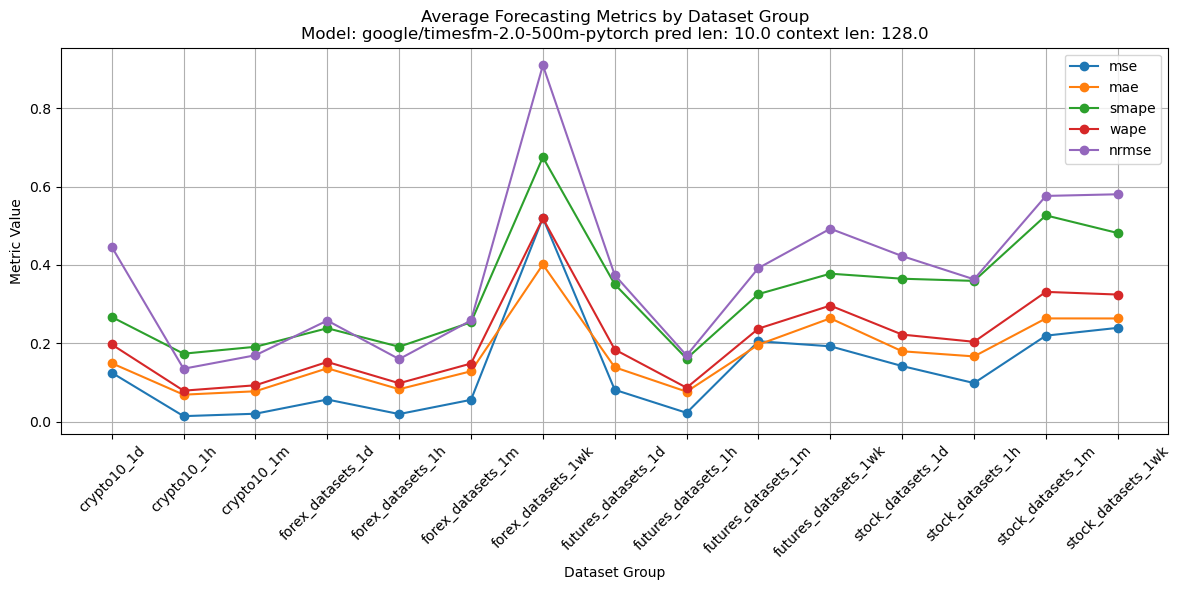


🔢 Total number of results.json files found: 908


In [5]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_500m_of1\h10")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.306698  0.380818  0.238696  0.317997  0.696533   3653.333333   
1   0.026006  0.226241  0.099422  0.114253  0.185372  20880.000000   
2   0.049619  0.264604  0.124838  0.149711  0.267086   8853.333333   
3   0.112654  0.332766  0.202327  0.226520  0.367477   6920.000000   
4   0.041968  0.261097  0.124648  0.147652  0.236065  20693.333333   
5   0.108403  0.327488  0.182215  0.210468  0.359945  12160.000000   
6   0.873817  0.849243  0.570297  0.743359  1.191053   2000.000000   
7   0.168540  0.473096  0.206826  0.275306  0.541821   7240.000000   
8   0.046070  0.238226  0.121479  0.137456  0.242869  16160.000000   
9   0.240037  0.389825  0.239044  0.287559  0.471192   9120.000000   
10  0.380214  0.542091  0.385130  0.440183  0.704758   2000.000000   
11  0.271497  0.479882  0.266099  0.330378  0.590177   6817.510730   
12  0.197539  0.474952  0.248370  0.304426  0.517552   5707.333333   
13  0.416945  0.677127  0.386639  0.488581  0.799783   2988.034188   
14  0.441842  0.616077  0.377241  0.469175  0.799467   2314.823529   

         abs_sum  total_time  pred_len  context_len                 group  
0    2840.513428    2.910954      20.0        128.0           crypto10_1d  
1   18160.557617   14.415530      20.0        128.0           crypto10_1h  
2    7392.073242    6.257392      20.0        128.0           crypto10_1m  
3    6179.074707    4.730810      20.0        128.0     forex_datasets_1d  
4   17704.054688   14.914697      20.0        128.0     forex_datasets_1h  
5   10519.006510    9.194974      20.0        128.0     forex_datasets_1m  
6    1563.865031    1.493857      20.0        128.0    forex_datasets_1wk  
7    5461.366089    4.774471      20.0        128.0   futures_datasets_1d  
8   14281.685547   11.927652      20.0        128.0   futures_datasets_1h  
9    7832.895752    6.190209      20.0        128.0   futures_datasets_1m  
10   1749.862793    1.396557      20.0        128.0  futures_datasets_1wk  
11   5585.289581    4.611813      20.0        128.0     stock_datasets_1d  
12   4735.984174    3.811800      20.0        128.0     stock_datasets_1h  
13   2386.358324    2.047849      20.0        128.0     stock_datasets_1m  
14   1895.490369    1.586675      20.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.2455
smape              0.4356
mae                0.2516
wape               0.3095
nrmse              0.5314
num_elements    8500.5135
abs_sum         7219.2052
total_time         6.0177
pred_len          20.0000
context_len      128.0000
dtype: float64


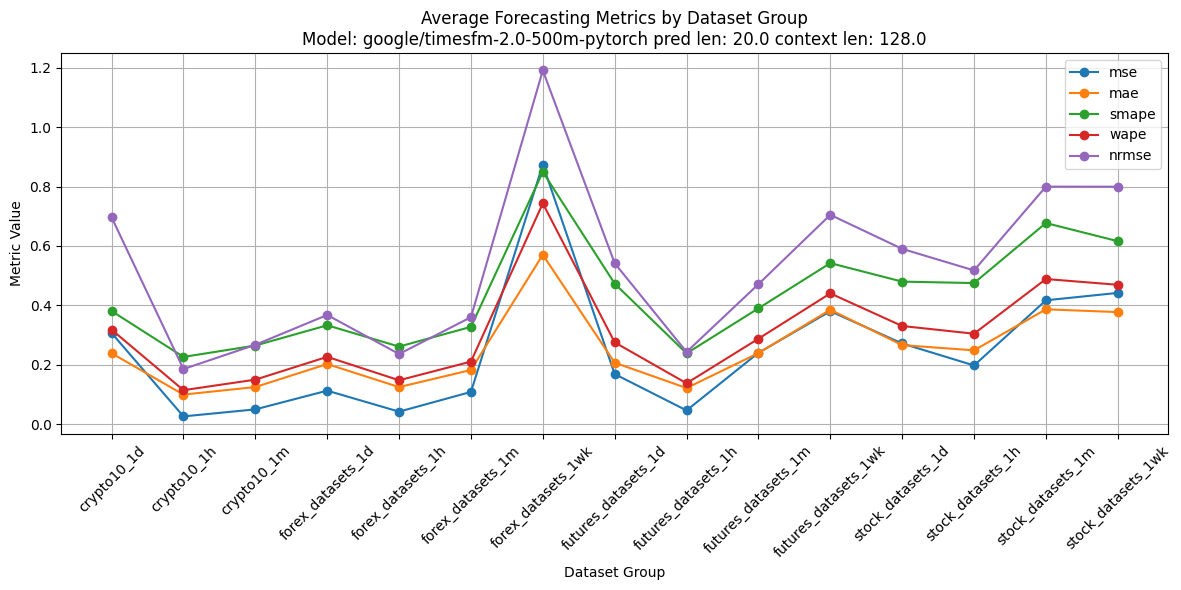


🔢 Total number of results.json files found: 908


In [6]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_500m_of1\h20")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.422928  0.429267  0.291890  0.385835  0.824827   3680.000000   
1   0.036966  0.268403  0.119624  0.137473  0.220985  20880.000000   
2   0.075099  0.325628  0.153516  0.185032  0.330067   8800.000000   
3   0.165569  0.381955  0.245213  0.274477  0.444683   6900.000000   
4   0.064356  0.309693  0.155408  0.185032  0.292967  20640.000000   
5   0.162479  0.393365  0.229059  0.264851  0.444750  12120.000000   
6   0.977598  0.887668  0.625461  0.806173  1.267911   2040.000000   
7   0.263044  0.552795  0.265755  0.354764  0.683320   7200.000000   
8   0.070561  0.304796  0.158508  0.179106  0.300153  16080.000000   
9   0.283871  0.444595  0.280405  0.336548  0.537450   9080.000000   
10  0.570665  0.602711  0.481186  0.540584  0.848674   2040.000000   
11  0.397927  0.563332  0.336807  0.417679  0.715756   6817.339056   
12  0.288964  0.553179  0.310084  0.382600  0.630441   5657.000000   
13  0.615825  0.801295  0.493837  0.627155  0.979284   2970.769231   
14  0.621079  0.698519  0.459153  0.566804  0.939759   2335.058824   

         abs_sum  total_time  pred_len  context_len                 group  
0    2867.131429    1.327957      30.0        128.0           crypto10_1d  
1   18160.559570    6.885046      30.0        128.0           crypto10_1h  
2    7310.747884    3.009890      30.0        128.0           crypto10_1m  
3    6164.434570    2.344885      30.0        128.0     forex_datasets_1d  
4   17603.581380    6.738590      30.0        128.0     forex_datasets_1h  
5   10474.398112    3.985664      30.0        128.0     forex_datasets_1m  
6    1600.562541    0.836473      30.0        128.0    forex_datasets_1wk  
7    5408.967285    2.390527      30.0        128.0   futures_datasets_1d  
8   14230.698242    5.630979      30.0        128.0   futures_datasets_1h  
9    7780.715047    2.968761      30.0        128.0   futures_datasets_1m  
10   1815.848877    1.166058      30.0        128.0  futures_datasets_1wk  
11   5581.527062    2.305473      30.0        128.0     stock_datasets_1d  
12   4669.511446    1.938084      30.0        128.0     stock_datasets_1h  
13   2365.816543    1.018325      30.0        128.0     stock_datasets_1m  
14   1920.600093    0.794728      30.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.3345
smape              0.5011
mae                0.3071
wape               0.3763
nrmse              0.6307
num_elements    8482.6778
abs_sum         7197.0067
total_time         2.8894
pred_len          30.0000
context_len      128.0000
dtype: float64


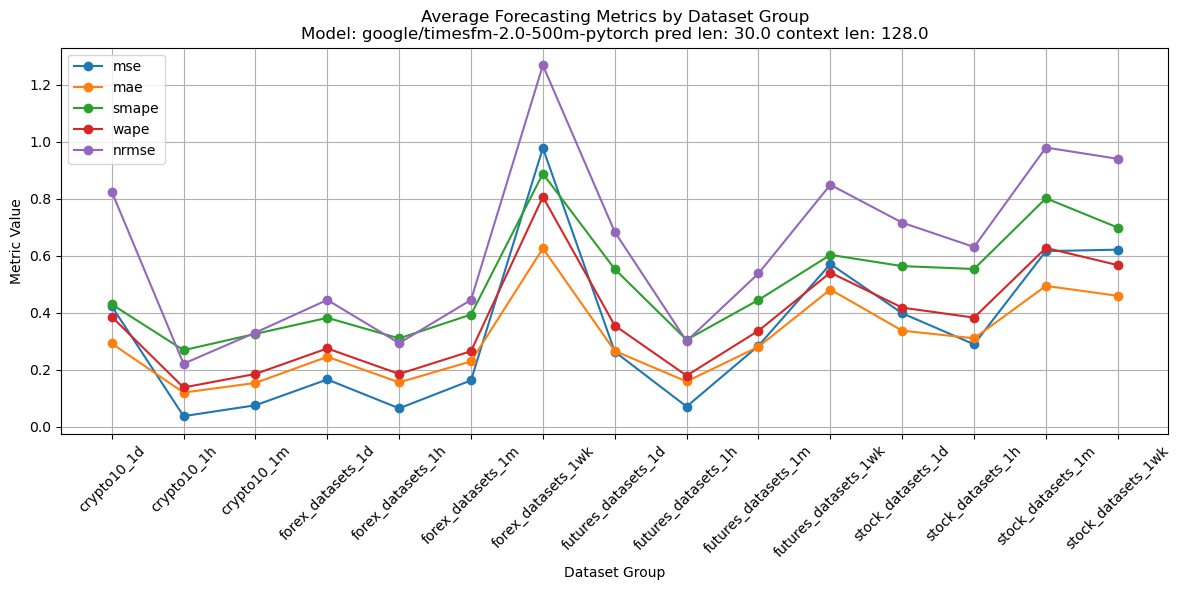


🔢 Total number of results.json files found: 908


In [6]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_500m_of1\h30")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.795929  0.618369  0.459739  0.622929  1.159239   3600.000000   
1   0.077281  0.361350  0.178267  0.204883  0.319571  20880.000000   
2   0.163141  0.439953  0.239053  0.288016  0.486098   8800.000000   
3   0.312607  0.541557  0.356569  0.397854  0.603354   6840.000000   
4   0.139881  0.411435  0.231190  0.275106  0.428826  20560.000000   
5   0.319056  0.530786  0.335243  0.388801  0.630204  12000.000000   
6   1.369664  1.048185  0.764694  0.986656  1.496807   1920.000000   
7   0.591408  0.700403  0.401643  0.542692  1.033779   7080.000000   
8   0.126302  0.384940  0.218827  0.247263  0.401574  16080.000000   
9   0.390160  0.542360  0.366622  0.436716  0.677906   9000.000000   
10  1.149438  0.842978  0.753052  0.872521  1.242207   1920.000000   
11  0.726304  0.725369  0.487161  0.610428  0.979246   6739.570815   
12  0.537705  0.710194  0.451318  0.558672  0.865026   5624.000000   
13  1.049090  1.002672  0.694190  0.887031  1.288882   2924.102564   
14  1.165469  0.914217  0.671596  0.856756  1.324145   2226.352941   

         abs_sum  total_time  pred_len  context_len                 group  
0    2775.409180    0.902629      60.0        128.0           crypto10_1d  
1   18160.557617    4.704183      60.0        128.0           crypto10_1h  
2    7310.747721    2.275101      60.0        128.0           crypto10_1m  
3    6124.638184    1.674391      60.0        128.0     forex_datasets_1d  
4   17539.440104    4.517032      60.0        128.0     forex_datasets_1h  
5   10344.388346    2.903332      60.0        128.0     forex_datasets_1m  
6    1488.001546    0.498453      60.0        128.0    forex_datasets_1wk  
7    5251.835938    1.655020      60.0        128.0   futures_datasets_1d  
8   14230.702148    3.676298      60.0        128.0   futures_datasets_1h  
9    7713.614176    2.064998      60.0        128.0   futures_datasets_1m  
10   1657.105225    0.530788      60.0        128.0  futures_datasets_1wk  
11   5482.854215    1.530249      60.0        128.0     stock_datasets_1d  
12   4633.335434    1.333708      60.0        128.0     stock_datasets_1h  
13   2310.156602    0.681304      60.0        128.0     stock_datasets_1m  
14   1774.437320    0.510389      60.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.5942
smape              0.6517
mae                0.4406
wape               0.5451
nrmse              0.8625
num_elements    8412.9351
abs_sum         7119.8149
total_time         1.9639
pred_len          60.0000
context_len      128.0000
dtype: float64


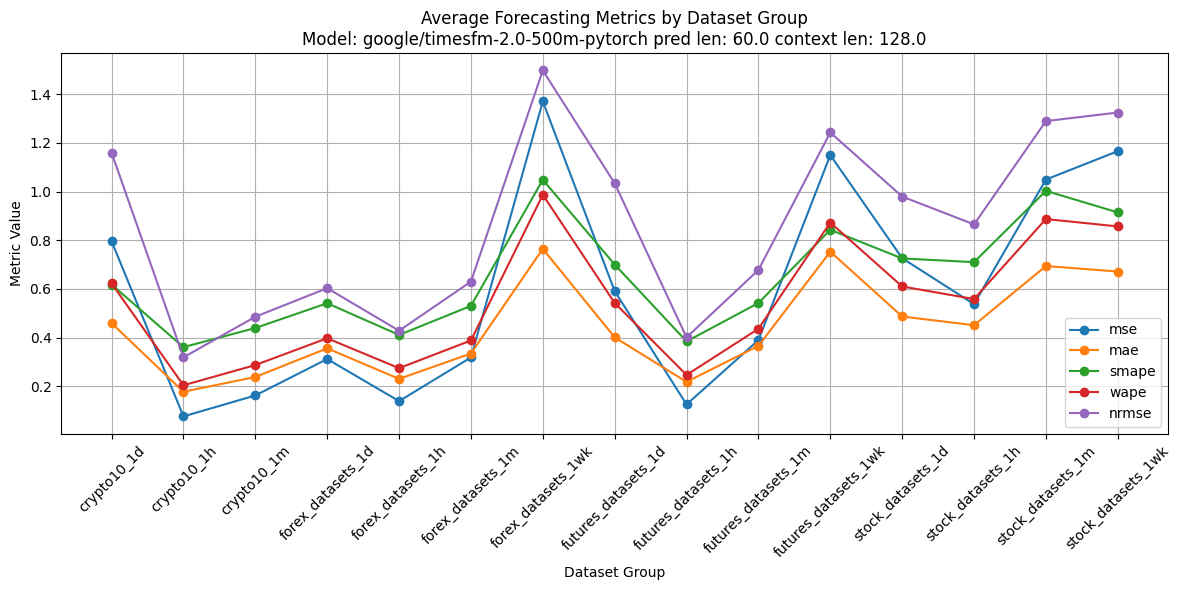


🔢 Total number of results.json files found: 908


In [7]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_500m_of1\h60")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   1.275651  0.777921  0.657820  0.901977  1.501043   3584.000000   
1   0.106263  0.419566  0.215820  0.248533  0.374963  20736.000000   
2   0.264981  0.571621  0.333160  0.406429  0.625476   8704.000000   
3   0.430594  0.654025  0.445811  0.505474  0.727587   6720.000000   
4   0.216686  0.494924  0.287013  0.340292  0.528097  20608.000000   
5   0.440671  0.609860  0.421853  0.490706  0.741928  11904.000000   
6   2.950444  1.356815  1.303821  1.685226  2.229202   1920.000000   
7   0.700693  0.792001  0.473009  0.631751  1.106400   7200.000000   
8   0.205973  0.481169  0.279272  0.315972  0.513485  16128.000000   
9   0.473364  0.619147  0.436363  0.517042  0.766018   9024.000000   
10  1.383617  1.030282  0.886093  1.026669  1.362885   1920.000000   
11  1.124430  0.872229  0.644044  0.809655  1.221183   6691.158798   
12  0.858569  0.851122  0.596278  0.744221  1.101670   5462.400000   
13  1.609927  1.162670  0.902524  1.186801  1.631460   2784.820513   
14  1.692507  1.107045  0.882402  1.125883  1.612225   2227.200000   

         abs_sum  total_time  pred_len  context_len                 group  
0    2755.319255    0.465700      96.0        128.0           crypto10_1d  
1   18006.963867    2.354477      96.0        128.0           crypto10_1h  
2    7165.317383    0.958935      96.0        128.0           crypto10_1m  
3    5925.901855    0.939740      96.0        128.0     forex_datasets_1d  
4   17631.636068    2.168664      96.0        128.0     forex_datasets_1h  
5   10240.671549    1.320845      96.0        128.0     forex_datasets_1m  
6    1488.001587    0.280996      96.0        128.0    forex_datasets_1wk  
7    5421.123291    0.814871      96.0        128.0   futures_datasets_1d  
8   14254.699219    1.804585      96.0        128.0   futures_datasets_1h  
9    7729.359985    0.957178      96.0        128.0   futures_datasets_1m  
10   1657.105225    0.385422      96.0        128.0  futures_datasets_1wk  
11   5419.960826    0.695982      96.0        128.0     stock_datasets_1d  
12   4471.765122    0.573851      96.0        128.0     stock_datasets_1h  
13   2165.623706    0.292127      96.0        128.0     stock_datasets_1m  
14   1777.973862    0.233538      96.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.9156
smape              0.7867
mae                0.5844
wape               0.7291
nrmse              1.0696
num_elements    8374.2386
abs_sum         7074.0949
total_time         0.9498
pred_len          96.0000
context_len      128.0000
dtype: float64


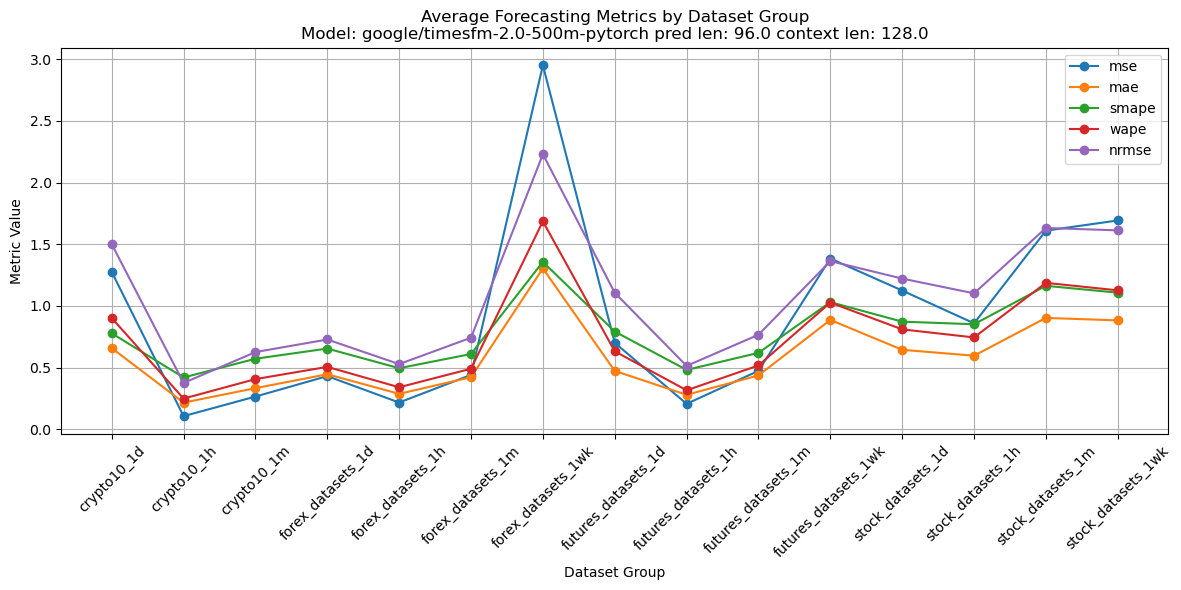


🔢 Total number of results.json files found: 908


In [4]:
#config
# Define the root result directory
root_dir = Path(r"results\tsfm\tsfm_500m_of1\h96")
show_results(root_dir)

## Chronos Small


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.081426  0.238725  0.125261  0.164601  0.367285   3693.333333   
1   0.012369  0.169115  0.064767  0.074424  0.127844  20880.000000   
2   0.018711  0.187764  0.074788  0.089424  0.163962   8853.333333   
3   0.053291  0.231359  0.133084  0.148974  0.251368   6920.000000   
4   0.017345  0.184163  0.077806  0.092096  0.152767  20720.000000   
5   0.053056  0.252548  0.127018  0.146622  0.251713  12200.000000   
6   0.569883  0.683119  0.381171  0.492638  0.949085   2040.000000   
7   0.078309  0.339406  0.130929  0.173804  0.366472   7280.000000   
8   0.020711  0.147608  0.072178  0.081671  0.162839  16160.000000   
9   0.241248  0.301909  0.196781  0.238104  0.406667   9140.000000   
10  0.176996  0.370522  0.250534  0.281460  0.472642   2040.000000   
11  0.123881  0.358474  0.171177  0.211793  0.399625   6843.948498   
12  0.094034  0.351009  0.160434  0.196410  0.354321   5714.333333   
13  0.210721  0.516507  0.255140  0.320538  0.564509   3010.427350   
14  0.212315  0.469656  0.247345  0.304706  0.546860   2347.058824   

         abs_sum  total_time  pred_len  context_len                 group  
0    2888.451090   12.179965      10.0        128.0           crypto10_1d  
1   18160.546875   67.433882      10.0        128.0           crypto10_1h  
2    7392.073730   43.416243      10.0        128.0           crypto10_1m  
3    6179.074219   22.293974      10.0        128.0     forex_datasets_1d  
4   17725.246745  133.904536      10.0        128.0     forex_datasets_1h  
5   10563.588867  111.384240      10.0        128.0     forex_datasets_1m  
6    1600.562581   17.181989      10.0        128.0    forex_datasets_1wk  
7    5514.909912   57.870918      10.0        128.0   futures_datasets_1d  
8   14281.680664  144.676470      10.0        128.0   futures_datasets_1h  
9    7848.489827   70.087270      10.0        128.0   futures_datasets_1m  
10   1815.848755   19.139751      10.0        128.0  futures_datasets_1wk  
11   5616.210387   57.995235      10.0        128.0     stock_datasets_1d  
12   4743.234716   50.527148      10.0        128.0     stock_datasets_1h  
13   2416.079607   27.086827      10.0        128.0     stock_datasets_1m  
14   1938.974565   20.132103      10.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1310
smape              0.3201
mae                0.1646
wape               0.2012
nrmse              0.3692
num_elements    8522.8290
abs_sum         7245.6648
total_time        57.0207
pred_len          10.0000
context_len      128.0000
dtype: float64


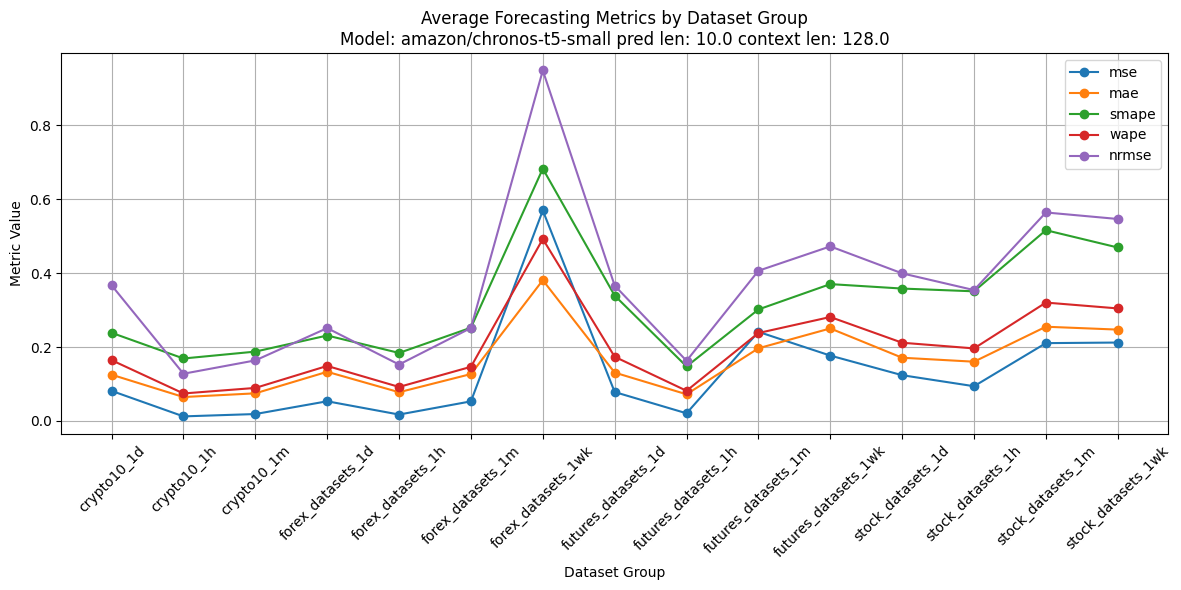


🔢 Total number of results.json files found: 908


In [3]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_small_of1\h10")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.174042  0.323902  0.187177  0.247453  0.540428   3653.333333   
1   0.023175  0.222296  0.091485  0.105129  0.175007  20880.000000   
2   0.045828  0.256784  0.118938  0.142468  0.256692   8853.333333   
3   0.099633  0.312902  0.187711  0.210016  0.342719   6920.000000   
4   0.034740  0.245297  0.113334  0.134124  0.216234  20693.333333   
5   0.092768  0.320519  0.171852  0.198619  0.330930  12160.000000   
6   0.711928  0.842384  0.511751  0.663671  1.088807   2000.000000   
7   0.159032  0.461554  0.195826  0.260376  0.523953   7240.000000   
8   0.039391  0.205909  0.108380  0.122634  0.224574  16160.000000   
9   0.263428  0.358405  0.232029  0.279639  0.465232   9120.000000   
10  0.350881  0.516633  0.368479  0.421152  0.677026   2000.000000   
11  0.227060  0.462908  0.244832  0.303773  0.545006   6817.510730   
12  0.180354  0.455726  0.232225  0.284666  0.492199   5707.333333   
13  0.381034  0.656524  0.362305  0.457341  0.763854   2988.034188   
14  0.374110  0.609197  0.352143  0.437749  0.738265   2314.823529   

         abs_sum  total_time  pred_len  context_len                 group  
0    2840.513428   10.529703      20.0        128.0           crypto10_1d  
1   18160.557617   64.544048      20.0        128.0           crypto10_1h  
2    7392.073242   28.150347      20.0        128.0           crypto10_1m  
3    6179.074707   22.405640      20.0        128.0     forex_datasets_1d  
4   17704.054688   60.124835      20.0        128.0     forex_datasets_1h  
5   10519.006510   34.380703      20.0        128.0     forex_datasets_1m  
6    1563.865031    5.706776      20.0        128.0    forex_datasets_1wk  
7    5461.366089   21.519947      20.0        128.0   futures_datasets_1d  
8   14281.685547   49.690794      20.0        128.0   futures_datasets_1h  
9    7832.895752   30.410280      20.0        128.0   futures_datasets_1m  
10   1749.862793    7.467386      20.0        128.0  futures_datasets_1wk  
11   5585.289581   21.652785      20.0        128.0     stock_datasets_1d  
12   4735.984174   17.982753      20.0        128.0     stock_datasets_1h  
13   2386.358324    9.369132      20.0        128.0     stock_datasets_1m  
14   1895.490369    7.223958      20.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.2105
smape              0.4167
mae                0.2319
wape               0.2846
nrmse              0.4921
num_elements    8500.5135
abs_sum         7219.2052
total_time        26.0773
pred_len          20.0000
context_len      128.0000
dtype: float64


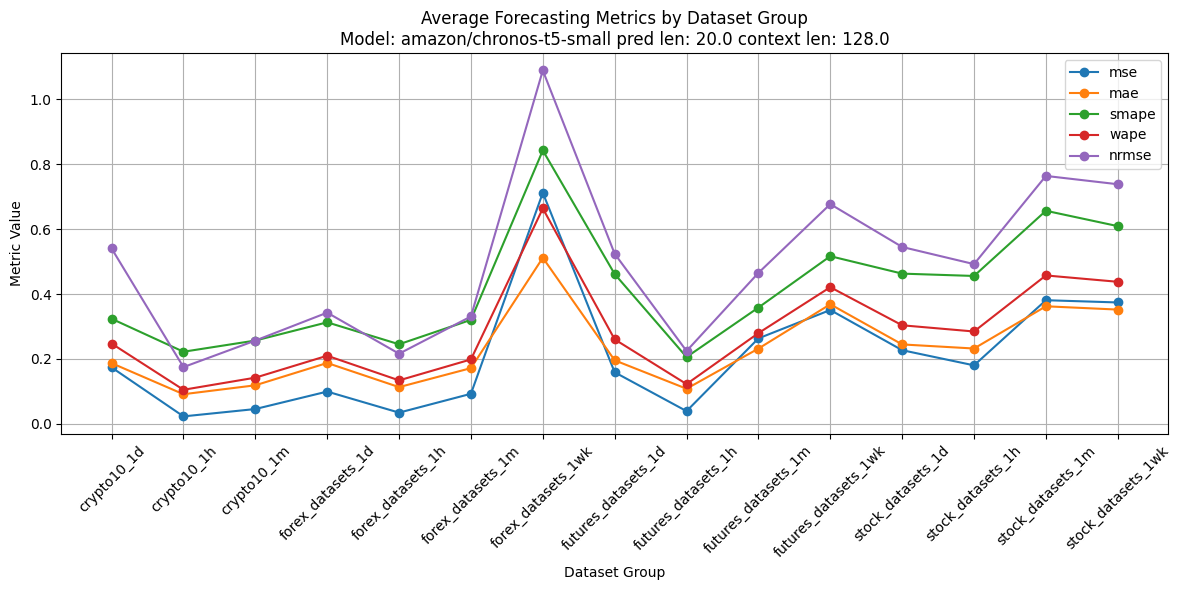


🔢 Total number of results.json files found: 908


In [4]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_small_of1\h20")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.289896  0.409634  0.260082  0.342617  0.693355   3680.000000   
1   0.032977  0.256272  0.109505  0.125837  0.208773  20880.000000   
2   0.071474  0.320106  0.148921  0.179200  0.322077   8800.000000   
3   0.157805  0.372206  0.241406  0.270031  0.433251   6900.000000   
4   0.051325  0.298498  0.139562  0.166122  0.262999  20640.000000   
5   0.142889  0.383144  0.220119  0.254731  0.414397  12120.000000   
6   1.361180  0.910317  0.605446  0.787873  1.461530   2040.000000   
7   0.236414  0.528927  0.242096  0.323089  0.643354   7200.000000   
8   0.060477  0.264083  0.141097  0.159432  0.277879  16080.000000   
9   0.294853  0.404824  0.265481  0.319107  0.517894   9080.000000   
10  0.507178  0.528885  0.426809  0.479495  0.800075   2040.000000   
11  0.320523  0.538893  0.302073  0.374148  0.649756   6817.339056   
12  0.250862  0.525566  0.282951  0.349022  0.584173   5657.000000   
13  0.555245  0.773743  0.457005  0.579949  0.928004   2970.769231   
14  0.508356  0.690386  0.424710  0.524433  0.856771   2335.058824   

         abs_sum  total_time  pred_len  context_len                 group  
0    2867.131429   29.692964      30.0        128.0           crypto10_1d  
1   18160.559570  170.124220      30.0        128.0           crypto10_1h  
2    7310.747884   74.924296      30.0        128.0           crypto10_1m  
3    6164.434570   55.795044      30.0        128.0     forex_datasets_1d  
4   17603.581380  159.390099      30.0        128.0     forex_datasets_1h  
5   10474.398112   96.985357      30.0        128.0     forex_datasets_1m  
6    1600.562541   17.276049      30.0        128.0    forex_datasets_1wk  
7    5408.967285   57.539677      30.0        128.0   futures_datasets_1d  
8   14230.698242  131.568218      30.0        128.0   futures_datasets_1h  
9    7780.715047   71.246546      30.0        128.0   futures_datasets_1m  
10   1815.848877   16.914641      30.0        128.0  futures_datasets_1wk  
11   5581.527062   46.680532      30.0        128.0     stock_datasets_1d  
12   4669.511446   16.839087      30.0        128.0     stock_datasets_1h  
13   2365.816543    8.642193      30.0        128.0     stock_datasets_1m  
14   1920.600093    6.702932      30.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.3228
smape              0.4804
mae                0.2845
wape               0.3490
nrmse              0.6036
num_elements    8482.6778
abs_sum         7197.0067
total_time        64.0215
pred_len          30.0000
context_len      128.0000
dtype: float64


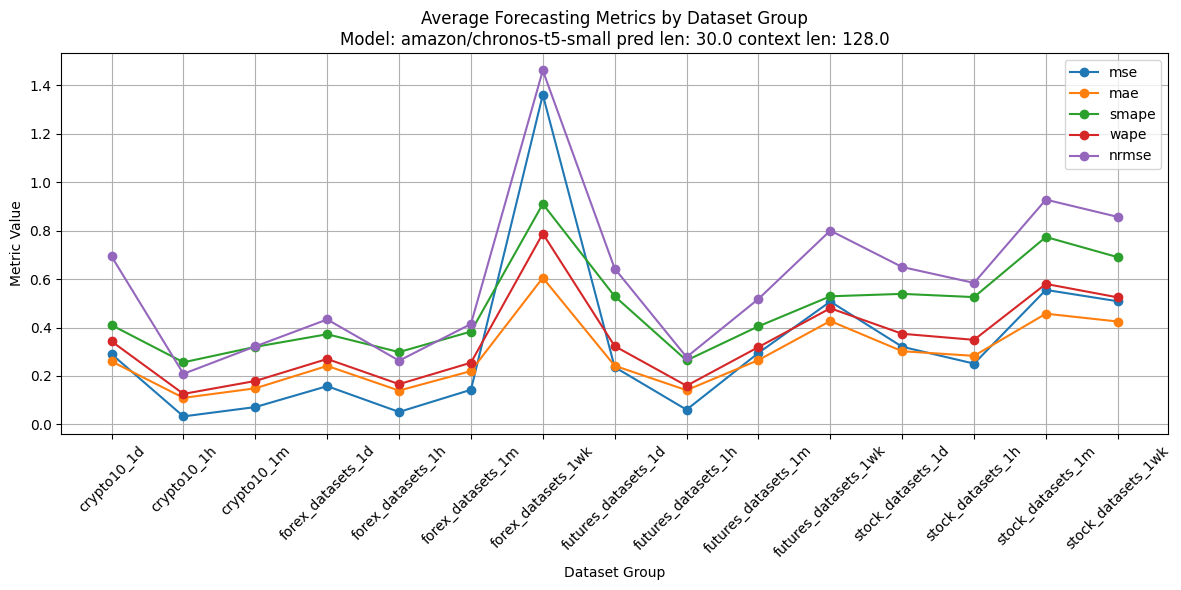


🔢 Total number of results.json files found: 908


In [5]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_small_of1\h30")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.567789  0.581395  0.399983  0.538858  0.987728   3600.000000   
1   0.068975  0.353220  0.163479  0.187845  0.301717  20880.000000   
2   0.154083  0.442800  0.236473  0.284203  0.472918   8800.000000   
3   0.290067  0.489633  0.333534  0.371995  0.581833   6840.000000   
4   0.104126  0.395198  0.198968  0.236485  0.374537  20560.000000   
5   0.271671  0.513978  0.313514  0.363748  0.581135  12000.000000   
6   2.546301  1.122427  0.808561  1.050909  2.040658   1920.000000   
7   0.465548  0.694122  0.356127  0.481339  0.914869   7080.000000   
8   0.125274  0.365876  0.209066  0.236235  0.399935  16080.000000   
9   0.374300  0.505648  0.340119  0.406109  0.637041   9000.000000   
10  1.024848  0.783664  0.671618  0.778168  1.172953   1920.000000   
11  0.563984  0.708829  0.432904  0.540610  0.870239   6739.570815   
12  0.436232  0.678289  0.400656  0.495655  0.776569   5624.000000   
13  0.912857  0.972981  0.636199  0.812771  1.201197   2924.102564   
14  0.867249  0.918731  0.603418  0.768624  1.162573   2226.352941   

         abs_sum  total_time  pred_len  context_len                 group  
0    2775.409180   10.321499      60.0        128.0           crypto10_1d  
1   18160.557617   60.056786      60.0        128.0           crypto10_1h  
2    7310.747721   25.092651      60.0        128.0           crypto10_1m  
3    6124.638184   19.470638      60.0        128.0     forex_datasets_1d  
4   17539.440104   58.480994      60.0        128.0     forex_datasets_1h  
5   10344.388346   33.143105      60.0        128.0     forex_datasets_1m  
6    1488.001546    5.209880      60.0        128.0    forex_datasets_1wk  
7    5251.835938   19.708202      60.0        128.0   futures_datasets_1d  
8   14230.702148   43.303938      60.0        128.0   futures_datasets_1h  
9    7713.614176   26.525703      60.0        128.0   futures_datasets_1m  
10   1657.105225    6.028775      60.0        128.0  futures_datasets_1wk  
11   5482.854215   19.099090      60.0        128.0     stock_datasets_1d  
12   4633.335434   15.949363      60.0        128.0     stock_datasets_1h  
13   2310.156602    8.417278      60.0        128.0     stock_datasets_1m  
14   1774.437320    6.464122      60.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.5849
smape              0.6351
mae                0.4070
wape               0.5036
nrmse              0.8317
num_elements    8412.9351
abs_sum         7119.8149
total_time        23.8181
pred_len          60.0000
context_len      128.0000
dtype: float64


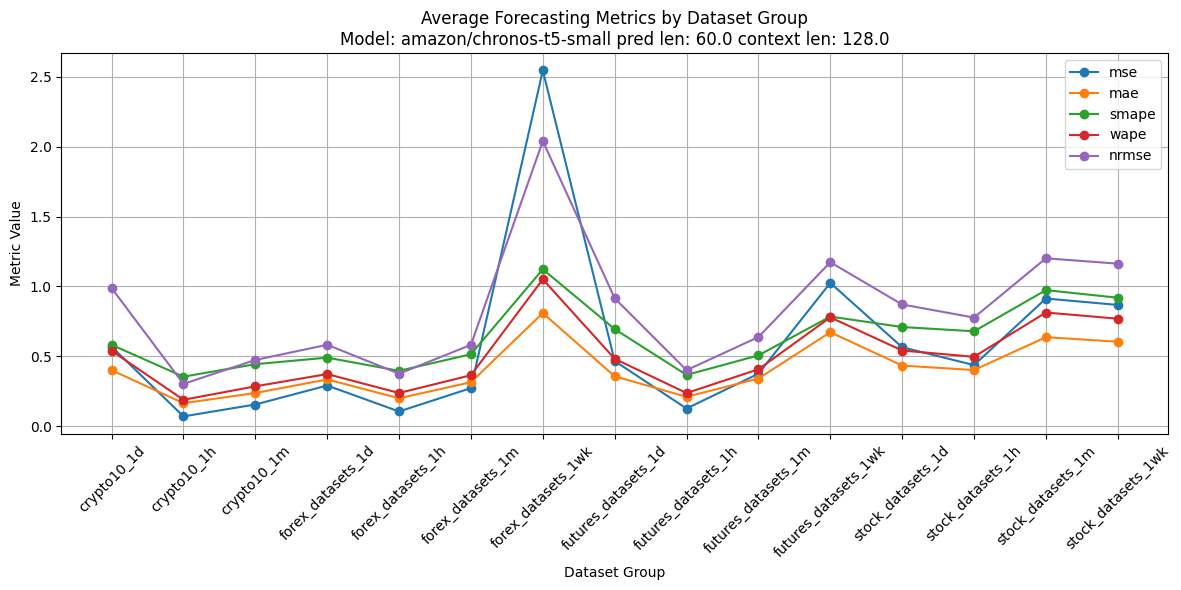


🔢 Total number of results.json files found: 908


In [6]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_small_of1\h60")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.706223  0.702327  0.486193  0.663573  1.104828   3584.000000   
1   0.113054  0.422288  0.207214  0.238626  0.386207  20736.000000   
2   0.274141  0.556153  0.327853  0.399782  0.636325   8704.000000   
3   0.407604  0.647256  0.419739  0.475895  0.707787   6720.000000   
4   0.160127  0.480077  0.253006  0.299662  0.460699  20608.000000   
5   0.349390  0.589880  0.379897  0.442216  0.660821  11904.000000   
6   2.379071  1.325591  1.018073  1.316242  2.001451   1920.000000   
7   0.711245  0.807831  0.449442  0.602132  1.103166   7200.000000   
8   0.183275  0.474131  0.264083  0.298788  0.484367  16128.000000   
9   0.444362  0.574044  0.400003  0.474402  0.733081   9024.000000   
10  1.524793  1.020349  0.883766  1.023973  1.430727   1920.000000   
11  0.800566  0.874756  0.563571  0.704872  1.051835   6691.158798   
12  0.658096  0.826566  0.526819  0.657003  0.967815   5462.400000   
13  1.304910  1.153377  0.806151  1.058371  1.467955   2784.820513   
14  1.172139  1.113890  0.761015  0.966455  1.357175   2227.200000   

         abs_sum  total_time  pred_len  context_len                 group  
0    2755.319255   11.016349      96.0        128.0           crypto10_1d  
1   18006.963867   63.044135      96.0        128.0           crypto10_1h  
2    7165.317383   26.376380      96.0        128.0           crypto10_1m  
3    5925.901855   19.768415      96.0        128.0     forex_datasets_1d  
4   17631.636068   58.303118      96.0        128.0     forex_datasets_1h  
5   10240.671549   34.048215      96.0        128.0     forex_datasets_1m  
6    1488.001587    5.587660      96.0        128.0    forex_datasets_1wk  
7    5421.123291   19.708756      96.0        128.0   futures_datasets_1d  
8   14254.699219   45.886300      96.0        128.0   futures_datasets_1h  
9    7729.359985   26.959775      96.0        128.0   futures_datasets_1m  
10   1657.105225    5.863358      96.0        128.0  futures_datasets_1wk  
11   5419.960826   18.459157      96.0        128.0     stock_datasets_1d  
12   4471.765122   14.966581      96.0        128.0     stock_datasets_1h  
13   2165.623706    7.726988      96.0        128.0     stock_datasets_1m  
14   1777.973862    6.247032      96.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.7459
smape              0.7712
mae                0.5165
wape               0.6415
nrmse              0.9703
num_elements    8374.2386
abs_sum         7074.0949
total_time        24.2641
pred_len          96.0000
context_len      128.0000
dtype: float64


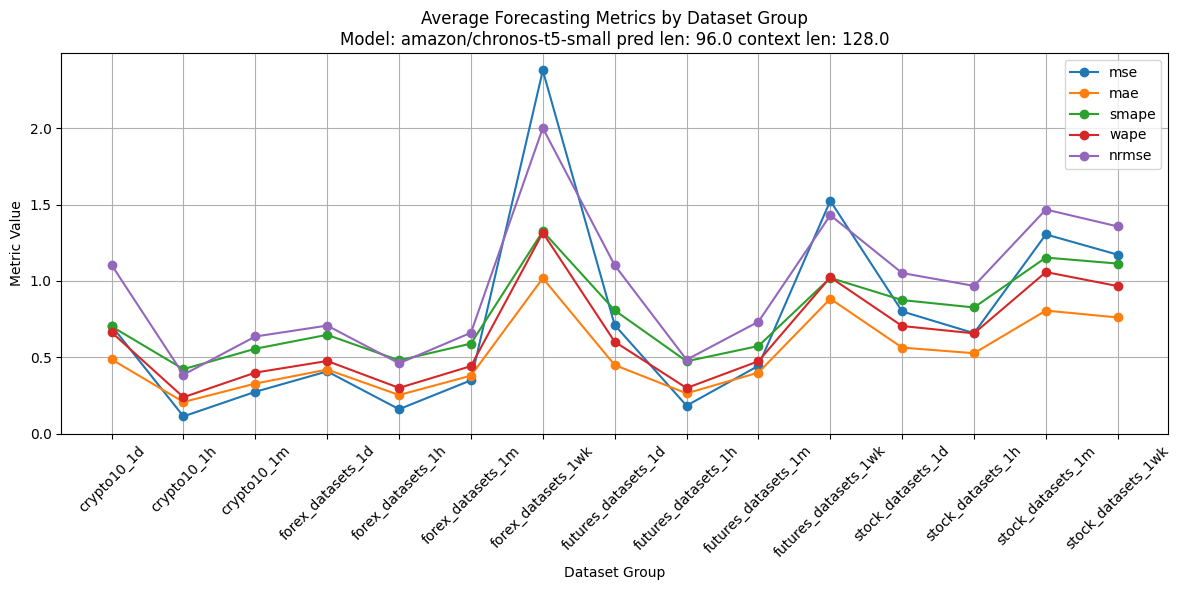


🔢 Total number of results.json files found: 908


In [7]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_small_of1\h96")
show_results(root_dir)

## Chronos Medium


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.083321  0.235177  0.126960  0.166727  0.372032   3693.333333   
1   0.012160  0.167344  0.064757  0.074416  0.126784  20880.000000   
2   0.018770  0.183108  0.074658  0.089324  0.164247   8853.333333   
3   0.051603  0.236014  0.133190  0.149078  0.248103   6920.000000   
4   0.017616  0.181168  0.078073  0.092443  0.153696  20720.000000   
5   0.065500  0.257821  0.131857  0.152257  0.272534  12200.000000   
6   0.529279  0.661211  0.367924  0.475562  0.899615   2040.000000   
7   0.077823  0.340459  0.131608  0.174662  0.365296   7280.000000   
8   0.021515  0.151495  0.074536  0.084339  0.165970  16160.000000   
9   0.245448  0.317186  0.205076  0.248402  0.409829   9140.000000   
10  0.172095  0.376958  0.252936  0.284159  0.466052   2040.000000   
11  0.140271  0.357107  0.172915  0.213972  0.413252   6843.948498   
12  0.094212  0.350486  0.160500  0.196480  0.354681   5714.333333   
13  0.211442  0.518381  0.255679  0.321247  0.565502   3010.427350   
14  0.211882  0.466708  0.246961  0.304202  0.546473   2347.058824   

         abs_sum  total_time  pred_len  context_len                 group  
0    2888.451090   14.703225      10.0        128.0           crypto10_1d  
1   18160.546875   81.690835      10.0        128.0           crypto10_1h  
2    7392.073730   34.687376      10.0        128.0           crypto10_1m  
3    6179.074219   27.247289      10.0        128.0     forex_datasets_1d  
4   17725.246745   81.280644      10.0        128.0     forex_datasets_1h  
5   10563.588867   47.919635      10.0        128.0     forex_datasets_1m  
6    1600.562581    8.155457      10.0        128.0    forex_datasets_1wk  
7    5514.909912   28.622781      10.0        128.0   futures_datasets_1d  
8   14281.680664   63.337532      10.0        128.0   futures_datasets_1h  
9    7848.489827   35.604113      10.0        128.0   futures_datasets_1m  
10   1815.848755    8.259315      10.0        128.0  futures_datasets_1wk  
11   5616.210387   26.634339      10.0        128.0     stock_datasets_1d  
12   4743.234716   22.281805      10.0        128.0     stock_datasets_1h  
13   2416.079607   11.762687      10.0        128.0     stock_datasets_1m  
14   1938.974565    9.177165      10.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1302
smape              0.3200
mae                0.1652
wape               0.2018
nrmse              0.3683
num_elements    8522.8290
abs_sum         7245.6648
total_time        33.4243
pred_len          10.0000
context_len      128.0000
dtype: float64


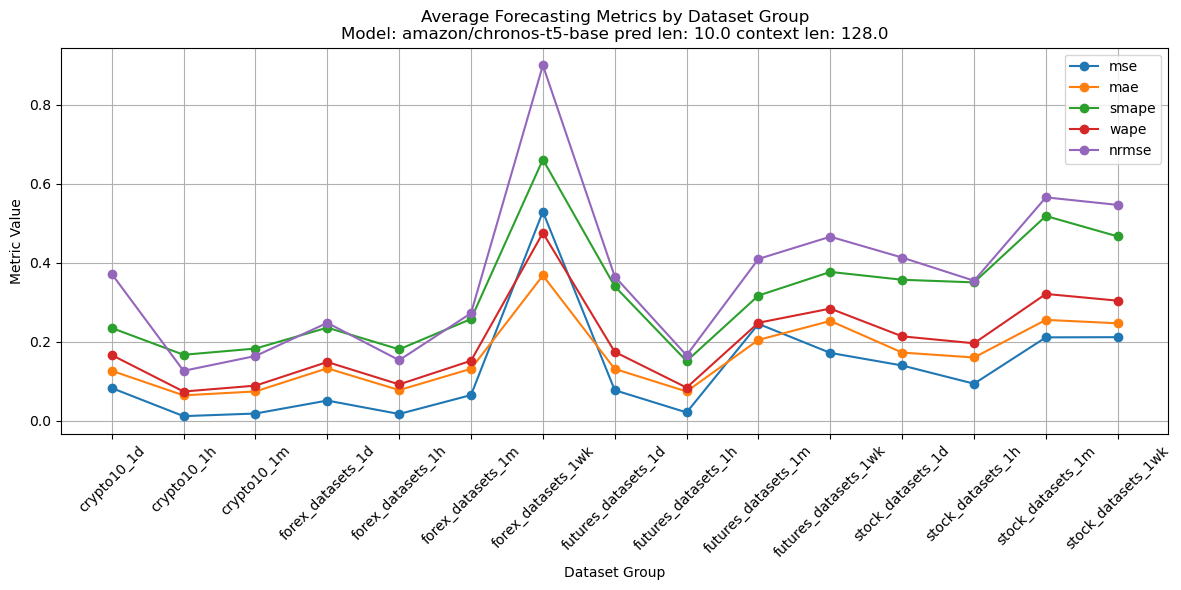


🔢 Total number of results.json files found: 908


In [10]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_medium_of1\h10")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.189030  0.325202  0.193800  0.255997  0.562175   3653.333333   
1   0.022463  0.217314  0.090949  0.104515  0.172314  20880.000000   
2   0.045453  0.258929  0.118816  0.142354  0.255641   8853.333333   
3   0.098249  0.323681  0.190858  0.213540  0.342040   6920.000000   
4   0.035349  0.243903  0.114050  0.135007  0.217922  20693.333333   
5   0.125556  0.331620  0.183275  0.211933  0.370630  12160.000000   
6   0.520282  0.816365  0.476959  0.617462  0.930996   2000.000000   
7   0.159650  0.458584  0.196314  0.261146  0.525147   7240.000000   
8   0.041569  0.218999  0.114477  0.129533  0.230698  16160.000000   
9   0.276225  0.373882  0.241718  0.291855  0.471529   9120.000000   
10  0.343613  0.532919  0.368217  0.420852  0.669979   2000.000000   
11  0.254972  0.461694  0.247563  0.307251  0.562871   6817.510730   
12  0.181134  0.455695  0.232319  0.284733  0.493398   5707.333333   
13  0.379339  0.663981  0.363607  0.458960  0.762573   2988.034188   
14  0.380839  0.603605  0.351759  0.437272  0.743972   2314.823529   

         abs_sum  total_time  pred_len  context_len                 group  
0    2840.513428   13.037087      20.0        128.0           crypto10_1d  
1   18160.557617   74.120396      20.0        128.0           crypto10_1h  
2    7392.073242   31.378415      20.0        128.0           crypto10_1m  
3    6179.074707   24.694171      20.0        128.0     forex_datasets_1d  
4   17704.054688   73.085600      20.0        128.0     forex_datasets_1h  
5   10519.006510   43.038003      20.0        128.0     forex_datasets_1m  
6    1563.865031    7.242395      20.0        128.0    forex_datasets_1wk  
7    5461.366089   25.694288      20.0        128.0   futures_datasets_1d  
8   14281.685547   57.365257      20.0        128.0   futures_datasets_1h  
9    7832.895752   32.199343      20.0        128.0   futures_datasets_1m  
10   1749.862793    7.545034      20.0        128.0  futures_datasets_1wk  
11   5585.289581   24.030738      20.0        128.0     stock_datasets_1d  
12   4735.984174   20.144911      20.0        128.0     stock_datasets_1h  
13   2386.358324   10.512234      20.0        128.0     stock_datasets_1m  
14   1895.490369    8.163898      20.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.2036
smape              0.4191
mae                0.2323
wape               0.2848
nrmse              0.4875
num_elements    8500.5135
abs_sum         7219.2052
total_time        30.1501
pred_len          20.0000
context_len      128.0000
dtype: float64


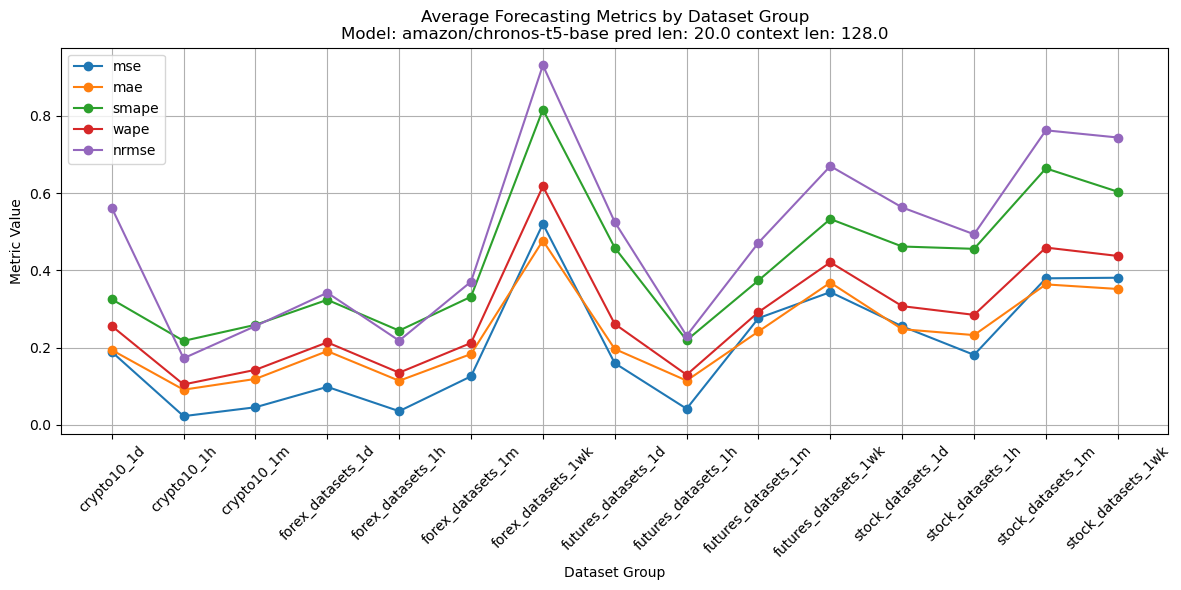


🔢 Total number of results.json files found: 908


In [11]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_medium_of1\h20")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.323615  0.407364  0.266197  0.350821  0.729501   3680.000000   
1   0.032079  0.259757  0.109269  0.125566  0.205927  20880.000000   
2   0.069177  0.321133  0.147455  0.177562  0.316840   8800.000000   
3   0.148195  0.367746  0.236429  0.264485  0.422478   6900.000000   
4   0.052525  0.297272  0.141093  0.167917  0.266314  20640.000000   
5   0.167255  0.388266  0.226900  0.262664  0.439636  12120.000000   
6   1.228303  0.906564  0.586857  0.762738  1.367259   2040.000000   
7   0.229134  0.525748  0.237619  0.317124  0.632376   7200.000000   
8   0.059484  0.262886  0.141894  0.160334  0.275589  16080.000000   
9   0.345779  0.428125  0.282848  0.340694  0.545721   9080.000000   
10  0.473156  0.523058  0.413528  0.464574  0.772774   2040.000000   
11  0.388596  0.539775  0.308261  0.381983  0.677667   6817.339056   
12  0.251231  0.524251  0.282494  0.348449  0.584487   5657.000000   
13  0.550334  0.782742  0.457519  0.580542  0.924653   2970.769231   
14  0.514780  0.689466  0.424877  0.524577  0.862070   2335.058824   

         abs_sum  total_time  pred_len  context_len                 group  
0    2867.131429   12.707376      30.0        128.0           crypto10_1d  
1   18160.559570   73.796457      30.0        128.0           crypto10_1h  
2    7310.747884   30.259997      30.0        128.0           crypto10_1m  
3    6164.434570   23.912120      30.0        128.0     forex_datasets_1d  
4   17603.581380   70.471757      30.0        128.0     forex_datasets_1h  
5   10474.398112   41.547138      30.0        128.0     forex_datasets_1m  
6    1600.562541    7.170566      30.0        128.0    forex_datasets_1wk  
7    5408.967285   24.832633      30.0        128.0   futures_datasets_1d  
8   14230.698242   55.514863      30.0        128.0   futures_datasets_1h  
9    7780.715047   31.109778      30.0        128.0   futures_datasets_1m  
10   1815.848877    7.327915      30.0        128.0  futures_datasets_1wk  
11   5581.527062   23.104827      30.0        128.0     stock_datasets_1d  
12   4669.511446   19.195553      30.0        128.0     stock_datasets_1h  
13   2365.816543   10.093953      30.0        128.0     stock_datasets_1m  
14   1920.600093    7.958276      30.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.3222
smape              0.4816
mae                0.2842
wape               0.3487
nrmse              0.6016
num_elements    8482.6778
abs_sum         7197.0067
total_time        29.2669
pred_len          30.0000
context_len      128.0000
dtype: float64


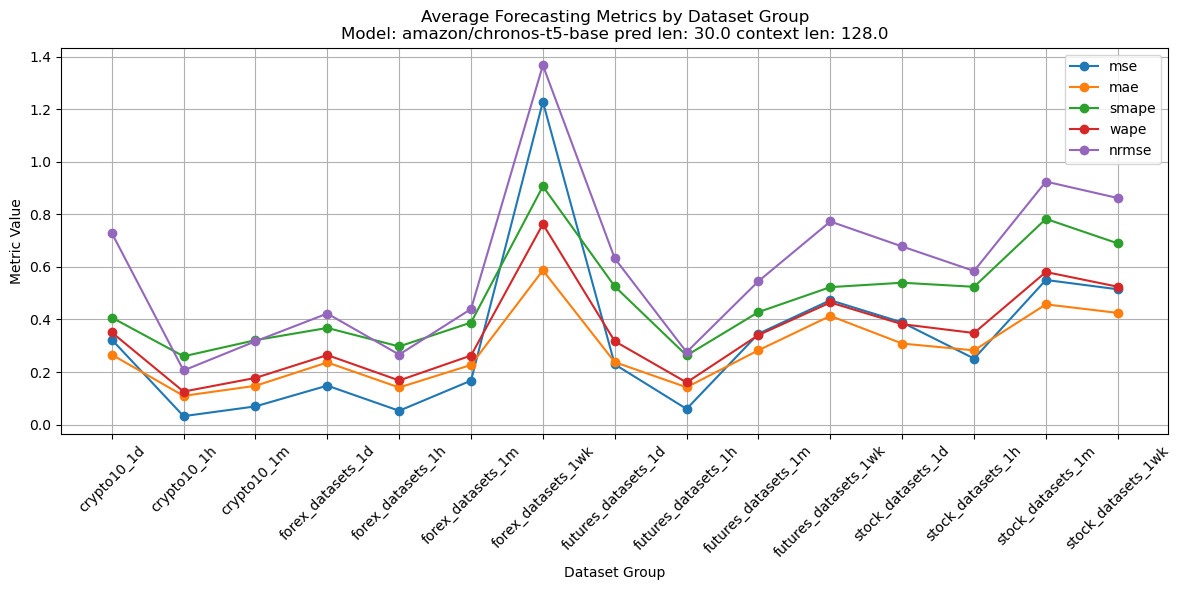


🔢 Total number of results.json files found: 908


In [12]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_medium_of1\h30")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.607564  0.564260  0.405005  0.545753  1.019291   3600.000000   
1   0.070448  0.353426  0.164386  0.188893  0.304954  20880.000000   
2   0.152610  0.444545  0.235769  0.283544  0.470644   8800.000000   
3   0.264955  0.481883  0.324761  0.362429  0.562918   6840.000000   
4   0.108775  0.396597  0.204273  0.242888  0.382196  20560.000000   
5   0.319583  0.532389  0.331728  0.385112  0.619048  12000.000000   
6   2.155125  1.099903  0.764741  0.995082  1.783581   1920.000000   
7   0.470784  0.682346  0.352932  0.476778  0.921911   7080.000000   
8   0.114182  0.364908  0.208125  0.235171  0.381821  16080.000000   
9   0.390757  0.526163  0.351946  0.420803  0.645181   9000.000000   
10  0.988795  0.742746  0.629165  0.728980  1.152137   1920.000000   
11  0.648079  0.712295  0.441861  0.554167  0.906041   6739.570815   
12  0.437054  0.677834  0.399431  0.494059  0.776894   5624.000000   
13  0.886377  0.988652  0.629287  0.803573  1.184296   2924.102564   
14  0.877215  0.925663  0.608252  0.774710  1.173088   2226.352941   

         abs_sum  total_time  pred_len  context_len                 group  
0    2775.409180   12.385406      60.0        128.0           crypto10_1d  
1   18160.557617   71.174293      60.0        128.0           crypto10_1h  
2    7310.747721   30.085735      60.0        128.0           crypto10_1m  
3    6124.638184   23.496845      60.0        128.0     forex_datasets_1d  
4   17539.440104   69.904022      60.0        128.0     forex_datasets_1h  
5   10344.388346   40.803659      60.0        128.0     forex_datasets_1m  
6    1488.001546    6.684373      60.0        128.0    forex_datasets_1wk  
7    5251.835938   24.141161      60.0        128.0   futures_datasets_1d  
8   14230.702148   55.123040      60.0        128.0   futures_datasets_1h  
9    7713.614176   30.547386      60.0        128.0   futures_datasets_1m  
10   1657.105225    6.893700      60.0        128.0  futures_datasets_1wk  
11   5482.854215   22.757832      60.0        128.0     stock_datasets_1d  
12   4633.335434   19.022652      60.0        128.0     stock_datasets_1h  
13   2310.156602    9.937779      60.0        128.0     stock_datasets_1m  
14   1774.437320    7.552529      60.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.5662
smape              0.6329
mae                0.4034
wape               0.4995
nrmse              0.8189
num_elements    8412.9351
abs_sum         7119.8149
total_time        28.7007
pred_len          60.0000
context_len      128.0000
dtype: float64


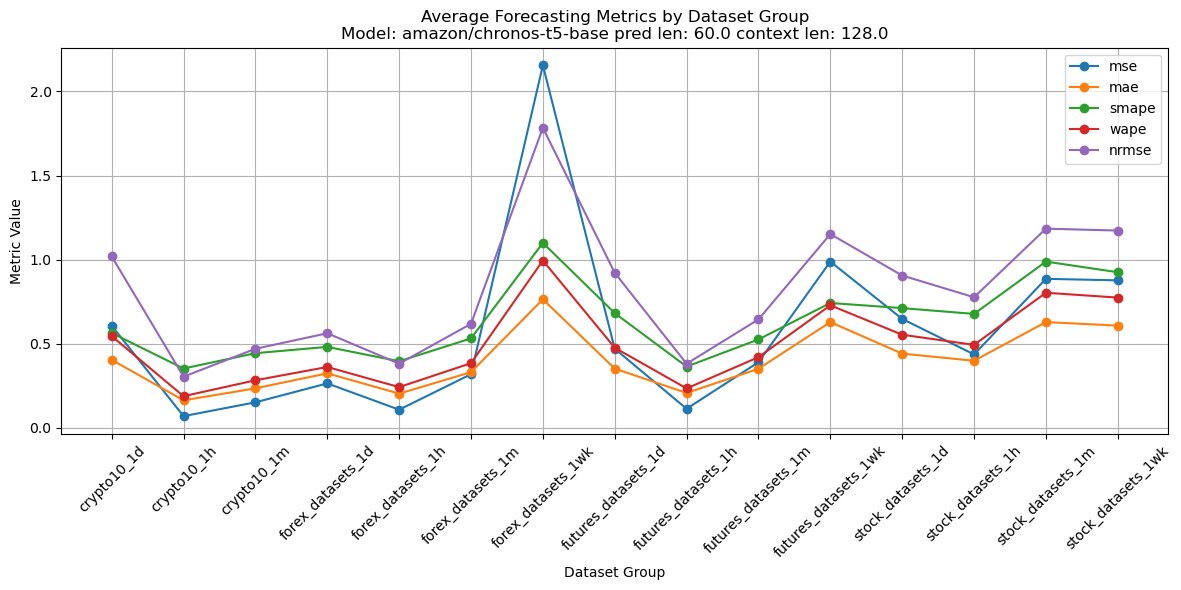


🔢 Total number of results.json files found: 908


In [13]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_medium_of1\h60")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.708525  0.696846  0.483989  0.659845  1.102559   3584.000000   
1   0.101196  0.411894  0.204036  0.234968  0.366157  20736.000000   
2   0.243668  0.546192  0.312213  0.381174  0.599517   8704.000000   
3   0.378065  0.667443  0.424724  0.481598  0.688477   6720.000000   
4   0.163525  0.477213  0.253566  0.300431  0.464522  20608.000000   
5   0.352218  0.582963  0.379235  0.441559  0.662454  11904.000000   
6   1.591650  1.305099  0.930035  1.194960  1.625928   1920.000000   
7   0.748208  0.819374  0.465678  0.623743  1.127711   7200.000000   
8   0.181402  0.475971  0.266348  0.301351  0.481885  16128.000000   
9   0.479201  0.593721  0.418510  0.497057  0.752982   9024.000000   
10  1.544224  1.154368  0.913310  1.058204  1.439814   1920.000000   
11  0.917026  0.877460  0.573765  0.720444  1.090139   6691.158798   
12  0.667937  0.833590  0.528944  0.659592  0.974411   5462.400000   
13  1.243992  1.157551  0.785642  1.030560  1.435402   2784.820513   
14  1.195759  1.113848  0.764658  0.971251  1.371009   2227.200000   

         abs_sum  total_time  pred_len  context_len                 group  
0    2755.319255   13.467461      96.0        128.0           crypto10_1d  
1   18006.963867   77.146982      96.0        128.0           crypto10_1h  
2    7165.317383   32.634545      96.0        128.0           crypto10_1m  
3    5925.901855   25.172517      96.0        128.0     forex_datasets_1d  
4   17631.636068   76.386687      96.0        128.0     forex_datasets_1h  
5   10240.671549   44.203011      96.0        128.0     forex_datasets_1m  
6    1488.001587    7.262284      96.0        128.0    forex_datasets_1wk  
7    5421.123291   26.874531      96.0        128.0   futures_datasets_1d  
8   14254.699219   60.253443      96.0        128.0   futures_datasets_1h  
9    7729.359985   33.568106      96.0        128.0   futures_datasets_1m  
10   1657.105225    7.485104      96.0        128.0  futures_datasets_1wk  
11   5419.960826   24.778607      96.0        128.0     stock_datasets_1d  
12   4471.765122   20.182526      96.0        128.0     stock_datasets_1h  
13   2165.623706   10.306329      96.0        128.0     stock_datasets_1m  
14   1777.973862    8.235691      96.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.7011
smape              0.7809
mae                0.5136
wape               0.6371
nrmse              0.9455
num_elements    8374.2386
abs_sum         7074.0949
total_time        31.1972
pred_len          96.0000
context_len      128.0000
dtype: float64


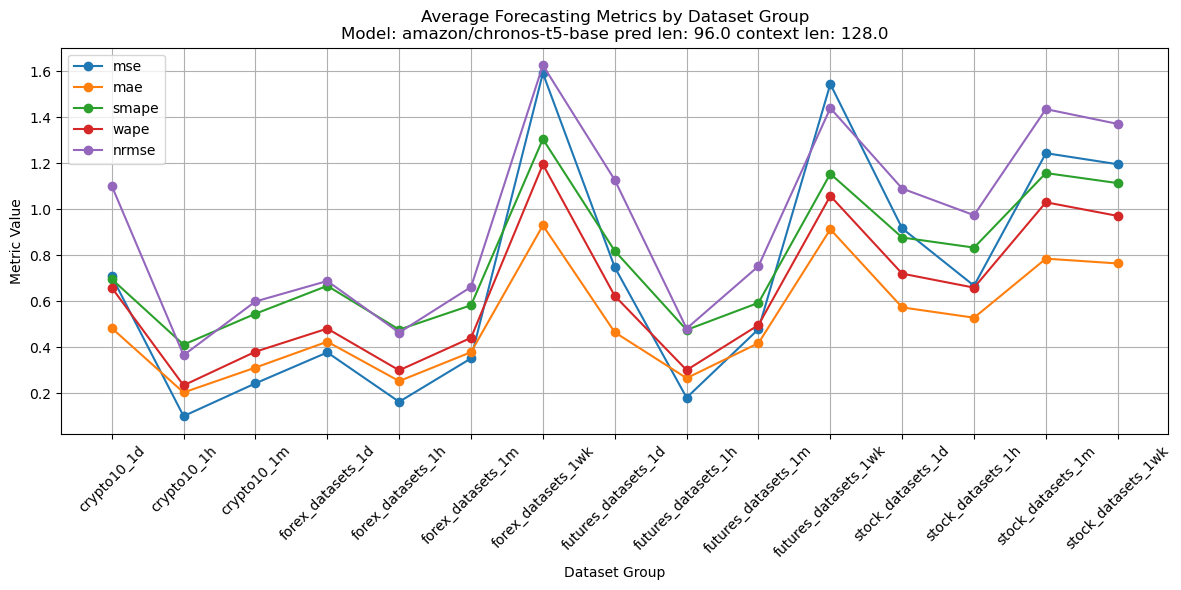


🔢 Total number of results.json files found: 908


In [14]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_medium_of1\h96")
show_results(root_dir)

## Chronos Large


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.084452  0.237782  0.128381  0.168544  0.374499   3693.333333   
1   0.012546  0.170378  0.065494  0.075259  0.128759  20880.000000   
2   0.019540  0.189099  0.076336  0.091359  0.167571   8853.333333   
3   0.051668  0.233454  0.132273  0.148053  0.248178   6920.000000   
4   0.017848  0.183706  0.078784  0.093302  0.154753  20720.000000   
5   0.052659  0.254048  0.126934  0.146534  0.250785  12200.000000   
6   0.317937  0.678366  0.357673  0.459817  0.723194   2040.000000   
7   0.075772  0.342895  0.130246  0.172881  0.360276   7280.000000   
8   0.020920  0.150718  0.073337  0.082983  0.163660  16160.000000   
9   0.251026  0.312684  0.203778  0.246843  0.412476   9140.000000   
10  0.172275  0.371384  0.250044  0.280910  0.466296   2040.000000   
11  0.138193  0.360092  0.172951  0.214151  0.408066   6843.948498   
12  0.094317  0.353565  0.161296  0.197442  0.355187   5714.333333   
13  0.208900  0.523317  0.256200  0.321956  0.562803   3010.427350   
14  0.211727  0.470550  0.247116  0.304443  0.546927   2347.058824   

         abs_sum  total_time  pred_len  context_len                 group  
0    2888.451090   39.333824      10.0        128.0           crypto10_1d  
1   18160.546875  210.615057      10.0        128.0           crypto10_1h  
2    7392.073730   88.621140      10.0        128.0           crypto10_1m  
3    6179.074219   73.363289      10.0        128.0     forex_datasets_1d  
4   17725.246745  211.094615      10.0        128.0     forex_datasets_1h  
5   10563.588867  119.072746      10.0        128.0     forex_datasets_1m  
6    1600.562581   20.617628      10.0        128.0    forex_datasets_1wk  
7    5514.909912   72.240477      10.0        128.0   futures_datasets_1d  
8   14281.680664  163.902997      10.0        128.0   futures_datasets_1h  
9    7848.489827   91.253684      10.0        128.0   futures_datasets_1m  
10   1815.848755   19.654851      10.0        128.0  futures_datasets_1wk  
11   5616.210387   73.678989      10.0        128.0     stock_datasets_1d  
12   4743.234716   60.197308      10.0        128.0     stock_datasets_1h  
13   2416.079607   31.839696      10.0        128.0     stock_datasets_1m  
14   1938.974565   24.207400      10.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1153
smape              0.3221
mae                0.1641
wape               0.2003
nrmse              0.3549
num_elements    8522.8290
abs_sum         7245.6648
total_time        86.6462
pred_len          10.0000
context_len      128.0000
dtype: float64


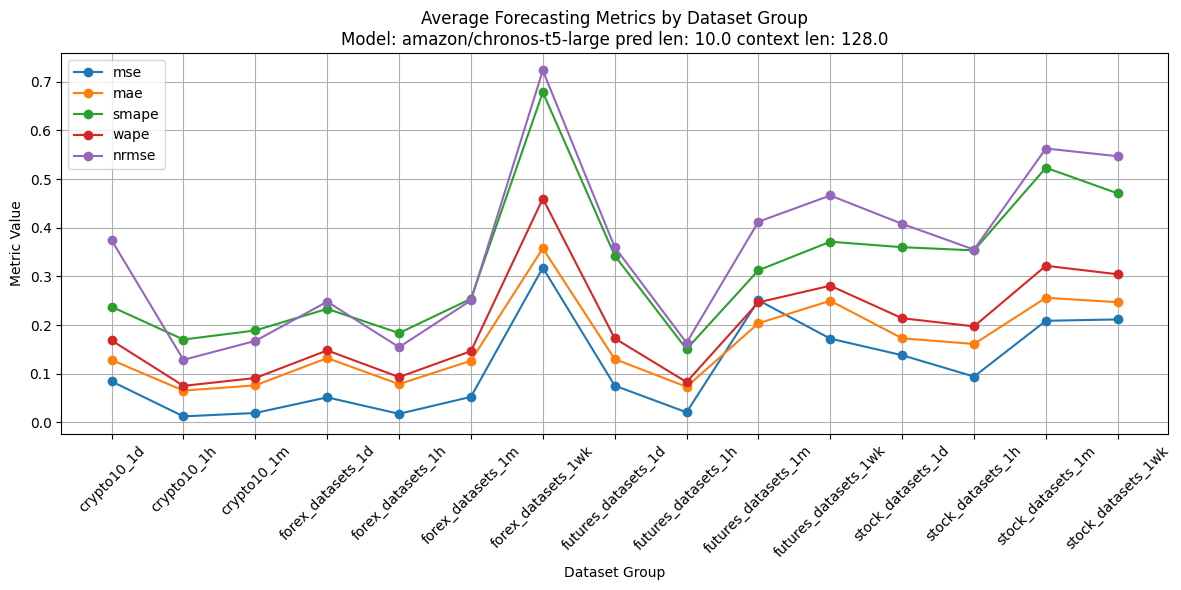


🔢 Total number of results.json files found: 908


In [3]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_Large_of1\h10")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.196406  0.333713  0.198339  0.262034  0.571655   3653.333333   
1   0.023049  0.221934  0.092614  0.106430  0.174550  20880.000000   
2   0.047285  0.264487  0.121156  0.145128  0.260743   8853.333333   
3   0.098005  0.323882  0.189339  0.211908  0.342078   6920.000000   
4   0.035392  0.244799  0.113811  0.134732  0.217913  20693.333333   
5   0.091167  0.319442  0.170178  0.196680  0.328407  12160.000000   
6   0.812772  0.848730  0.515517  0.670031  1.143548   2000.000000   
7   0.156375  0.461620  0.194977  0.259235  0.519764   7240.000000   
8   0.040342  0.217784  0.111455  0.126114  0.227269  16160.000000   
9   0.279326  0.371781  0.241223  0.291234  0.472415   9120.000000   
10  0.344890  0.529238  0.364383  0.416471  0.671223   2000.000000   
11  0.231127  0.467025  0.246867  0.306000  0.546911   6817.510730   
12  0.180938  0.460683  0.233463  0.286163  0.493436   5707.333333   
13  0.374257  0.671401  0.363826  0.459374  0.757769   2988.034188   
14  0.373875  0.611227  0.352012  0.437599  0.739405   2314.823529   

         abs_sum  total_time  pred_len  context_len                 group  
0    2840.513428   37.929979      20.0        128.0           crypto10_1d  
1   18160.557617  200.769257      20.0        128.0           crypto10_1h  
2    7392.073242   84.953286      20.0        128.0           crypto10_1m  
3    6179.074707   64.494806      20.0        128.0     forex_datasets_1d  
4   17704.054688  215.553770      20.0        128.0     forex_datasets_1h  
5   10519.006510  119.491658      20.0        128.0     forex_datasets_1m  
6    1563.865031   20.082901      20.0        128.0    forex_datasets_1wk  
7    5461.366089   74.726542      20.0        128.0   futures_datasets_1d  
8   14281.685547  164.672206      20.0        128.0   futures_datasets_1h  
9    7832.895752   92.938514      20.0        128.0   futures_datasets_1m  
10   1749.862793   20.746673      20.0        128.0  futures_datasets_1wk  
11   5585.289581   69.367366      20.0        128.0     stock_datasets_1d  
12   4735.984174   56.445798      20.0        128.0     stock_datasets_1h  
13   2386.358324   28.448246      20.0        128.0     stock_datasets_1m  
14   1895.490369   21.307412      20.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.2190
smape              0.4232
mae                0.2339
wape               0.2873
nrmse              0.4978
num_elements    8500.5135
abs_sum         7219.2052
total_time        84.7952
pred_len          20.0000
context_len      128.0000
dtype: float64


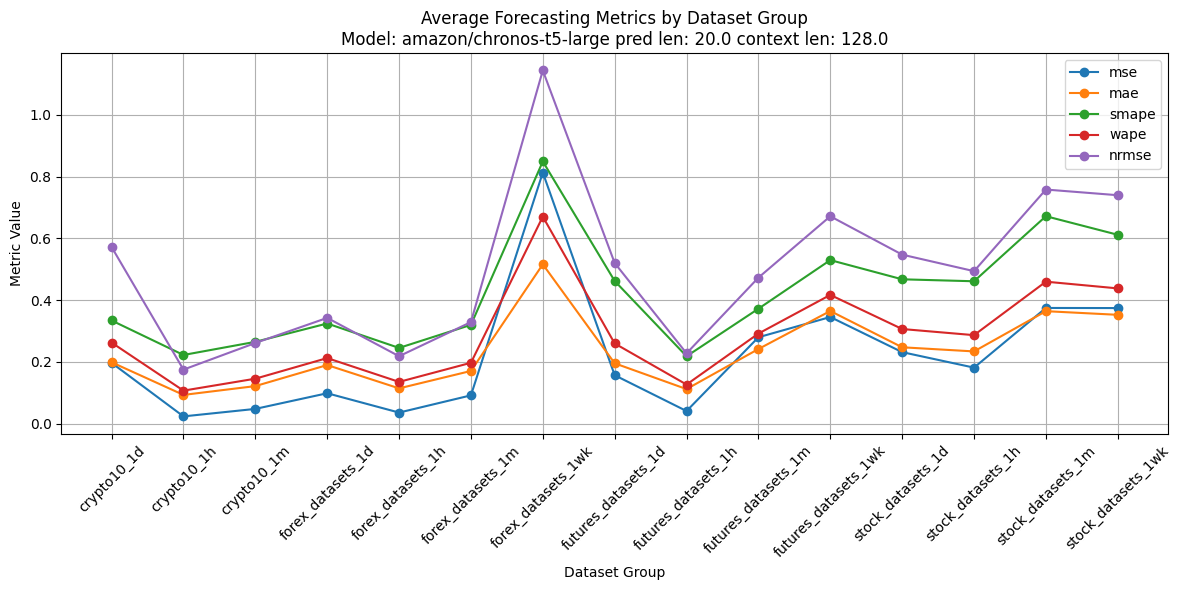


🔢 Total number of results.json files found: 908


In [4]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_Large_of1\h20")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.332895  0.412854  0.270475  0.356602  0.737327   3680.000000   
1   0.032996  0.260326  0.110414  0.126880  0.208802  20880.000000   
2   0.073216  0.329190  0.151773  0.182708  0.326005   8800.000000   
3   0.150352  0.366475  0.236777  0.264961  0.426089   6900.000000   
4   0.052543  0.300194  0.141186  0.168039  0.266181  20640.000000   
5   0.138961  0.377065  0.215317  0.249152  0.409240  12120.000000   
6   1.294551  0.940920  0.601480  0.782146  1.408652   2040.000000   
7   0.223664  0.528513  0.236329  0.315208  0.624438   7200.000000   
8   0.059508  0.271627  0.141397  0.159772  0.275644  16080.000000   
9   0.306899  0.428067  0.277038  0.333315  0.526046   9080.000000   
10  0.487638  0.525073  0.418012  0.469612  0.784511   2040.000000   
11  0.356269  0.544709  0.306163  0.379431  0.663242   6817.339056   
12  0.251061  0.531464  0.284238  0.350572  0.584725   5657.000000   
13  0.549003  0.793885  0.459615  0.583163  0.924262   2970.769231   
14  0.507329  0.697376  0.424984  0.524674  0.858620   2335.058824   

         abs_sum  total_time  pred_len  context_len                 group  
0    2867.131429   33.743082      30.0        128.0           crypto10_1d  
1   18160.559570  193.159849      30.0        128.0           crypto10_1h  
2    7310.747884   80.171873      30.0        128.0           crypto10_1m  
3    6164.434570   60.160449      30.0        128.0     forex_datasets_1d  
4   17603.581380  181.865769      30.0        128.0     forex_datasets_1h  
5   10474.398112  110.105397      30.0        128.0     forex_datasets_1m  
6    1600.562541   19.261899      30.0        128.0    forex_datasets_1wk  
7    5408.967285   66.897531      30.0        128.0   futures_datasets_1d  
8   14230.698242  144.569359      30.0        128.0   futures_datasets_1h  
9    7780.715047   85.004131      30.0        128.0   futures_datasets_1m  
10   1815.848877   18.327785      30.0        128.0  futures_datasets_1wk  
11   5581.527062   62.395120      30.0        128.0     stock_datasets_1d  
12   4669.511446   51.887194      30.0        128.0     stock_datasets_1h  
13   2365.816543   29.902289      30.0        128.0     stock_datasets_1m  
14   1920.600093   21.668103      30.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.3211
smape              0.4872
mae                0.2850
wape               0.3497
nrmse              0.6016
num_elements    8482.6778
abs_sum         7197.0067
total_time        77.2747
pred_len          30.0000
context_len      128.0000
dtype: float64


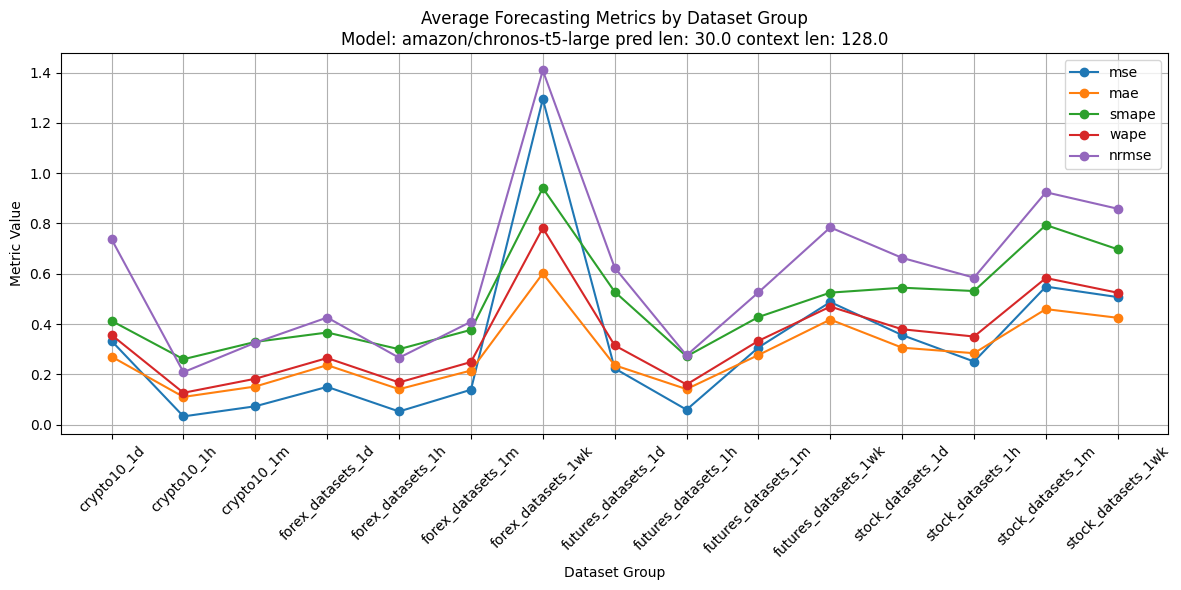


🔢 Total number of results.json files found: 908


In [5]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_Large_of1\h30")
show_results(root_dir)


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.643218  0.590948  0.419103  0.564237  1.048758   3600.000000   
1   0.068730  0.352962  0.163251  0.187587  0.301147  20880.000000   
2   0.166226  0.462701  0.244808  0.294638  0.491211   8800.000000   
3   0.259043  0.473822  0.320179  0.357291  0.555965   6840.000000   
4   0.110148  0.403529  0.206417  0.245428  0.384713  20560.000000   
5   0.273528  0.516439  0.317942  0.368994  0.582965  12000.000000   
6   1.855361  1.146159  0.749964  0.974711  1.672655   1920.000000   
7   0.463714  0.698831  0.353511  0.477318  0.915909   7080.000000   
8   0.118351  0.376401  0.209342  0.236546  0.388728  16080.000000   
9   0.389102  0.529866  0.355482  0.424806  0.647424   9000.000000   
10  0.988808  0.781713  0.643243  0.745292  1.152145   1920.000000   
11  0.597823  0.720267  0.437874  0.548347  0.885544   6739.570815   
12  0.437367  0.688875  0.402445  0.497781  0.777841   5624.000000   
13  0.881065  1.003509  0.632223  0.807626  1.181542   2924.102564   
14  0.860874  0.936415  0.605350  0.770467  1.164970   2226.352941   

         abs_sum  total_time  pred_len  context_len                 group  
0    2775.409180   41.175385      60.0        128.0           crypto10_1d  
1   18160.557617  202.357997      60.0        128.0           crypto10_1h  
2    7310.747721   78.841863      60.0        128.0           crypto10_1m  
3    6124.638184   60.877009      60.0        128.0     forex_datasets_1d  
4   17539.440104  184.384645      60.0        128.0     forex_datasets_1h  
5   10344.388346  107.023547      60.0        128.0     forex_datasets_1m  
6    1488.001546   17.219370      60.0        128.0    forex_datasets_1wk  
7    5251.835938   64.882941      60.0        128.0   futures_datasets_1d  
8   14230.702148  140.465945      60.0        128.0   futures_datasets_1h  
9    7713.614176   81.659793      60.0        128.0   futures_datasets_1m  
10   1657.105225   18.549270      60.0        128.0  futures_datasets_1wk  
11   5482.854215   61.705779      60.0        128.0     stock_datasets_1d  
12   4633.335434   50.728556      60.0        128.0     stock_datasets_1h  
13   2310.156602   27.144498      60.0        128.0     stock_datasets_1m  
14   1774.437320   20.653050      60.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.5409
smape              0.6455
mae                0.4041
wape               0.5001
nrmse              0.8101
num_elements    8412.9351
abs_sum         7119.8149
total_time        77.1780
pred_len          60.0000
context_len      128.0000
dtype: float64


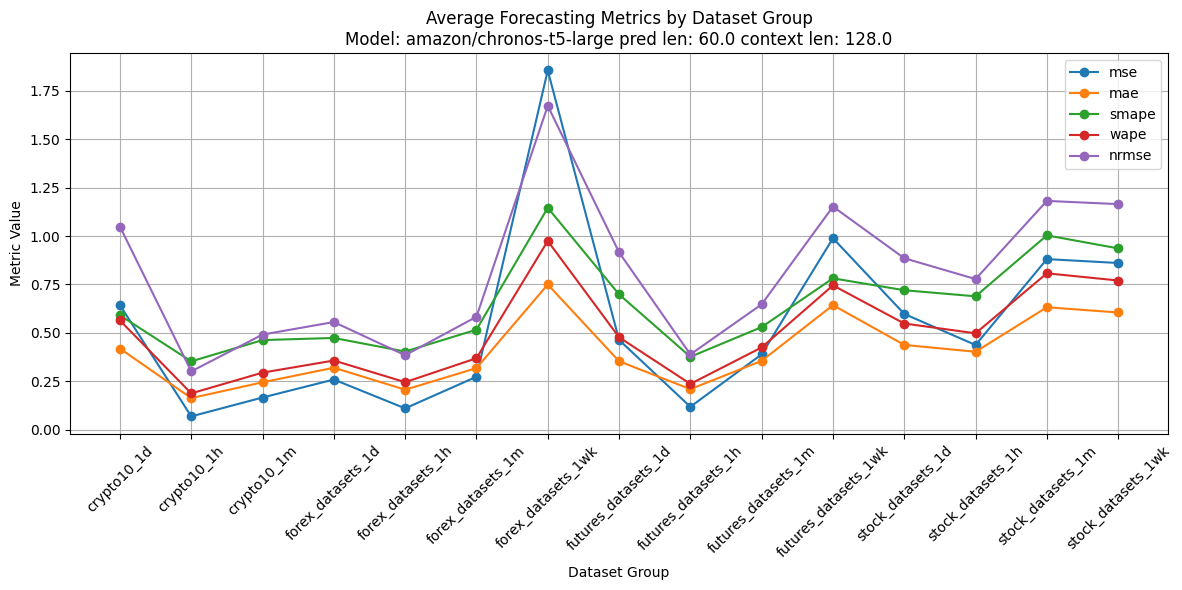


🔢 Total number of results.json files found: 908


In [6]:
#config
# Define the root result directory
root_dir = Path(r"results\chronos\chronos_Large_of1\h60")
show_results(root_dir)

In [ ]:
#config
# Define the root result directory
root_dir = Path(r"")
show_results(root_dir)